# Chapter 16: Real life full project

注意： 
1. 这里是多分类，taget为(-1,0,1)
2. feature里，一定要加shift(1)，代表上一天的数据，防止数据泄露。而label不用shift

Changes,
使用了add_target_label()里生成的label
predictor()/Voting(), 里添加了multiclass=False, 设为True即为多分类。


In [1]:
# !pip install ta

In [2]:
import numpy as np
import pandas as pd
# import MetaTrader5 as mt5
import time
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
# mt5.initialize()
import ta

import pickle
from joblib import dump, load

In [3]:
# 数据长度
# TODO:
N_month = 12
N_daily_data = 4*24
data_len = N_month*30*N_daily_data
print("data len is ", data_len)

# 跳过第几个
N_SKIP=0
# 取Asset的个数
N_SEL_ASSETS=10

N_PCA_COMPONENT=30

is_PROD=True

multiclass = True

data len is  34560


### 16.1.1. Importation of the data

In [12]:
import os
data_path="data"
symbol_list=[]
dirs = os.listdir( data_path )

# 输出所有文件和文件夹
for file in dirs:
#     print(file)
    symbol_list.append(file[:-4])

print(symbol_list)

['AAVE_USDT', 'ADA_USDT', 'ALGO_USDT', 'APE_USDT', 'AR_USDT', 'ATOM_USDT', 'AVAX_USDT', 'AXS_USDT', 'BAT_USDT', 'BCH_USDT', 'BNB_USDT', 'BTC_USDT', 'CHZ_USDT', 'COMP_USDT', 'DASH_USDT', 'DOGE_USDT', 'DOT_USDT', 'EGLD_USDT', 'ENJ_USDT', 'ENS_USDT', 'EOS_USDT', 'ETC_USDT', 'ETH_USDT', 'FIL_USDT', 'FLOW_USDT', 'FTM_USDT', 'FTT_USDT', 'GALA_USDT', 'GMT_USDT', 'GRT_USDT', 'HBAR_USDT', 'HNT_USDT', 'IOST_USDT', 'IOTA_USDT', 'IOTX_USDT', 'KAVA_USDT', 'KLAY_USDT', 'LDO_USDT', 'LINK_USDT', 'LTC_USDT', 'MANA_USDT', 'MATIC_USDT', 'MKR_USDT', 'NEAR_USDT', 'NEO_USDT', 'QTUM_USDT', 'ROSE_USDT', 'RSR_USDT', 'RUNE_USDT', 'RVN_USDT', 'SAND_USDT', 'SNX_USDT', 'SOL_USDT', 'SRM_USDT', 'THETA_USDT', 'TRX_USDT', 'UNI_USDT', 'VET_USDT', 'WAVES_USDT', 'XLM_USDT', 'XMR_USDT', 'XRP_USDT', 'XTZ_USDT', 'ZEC_USDT', 'ZIL_USDT']


#### 过滤不能交易的symbol

In [5]:
import ccxt

untradable_list=[]


exchange = ccxt.binanceusdm({ 'options': { 'adjustForTimeDifference': True }})
exchange

def _fetch_and_convert(symbol, target, orig_symbol, step):
    try:
        ticker = symbol + "/" + target
        print(ticker)
        price =  float(exchange.fetchTicker(ticker)['last'])
    except: 
        ticker = target + "/" + symbol
        price =  1/float(exchange.fetchTicker(ticker)['last'])
        
    print("price is ", price)
    
def check_if_tradable(symbol, dest=None):  
    if dest is not None:
        target = dest
        try:
            _fetch_and_convert(symbol = symbol, target = target, orig_symbol = symbol, step = "first")
        except Exception as e:
            print("{} can´t be converted to {}!".format(symbol, dest))
            untradable_list.append(symbol)           
    
    else:
        try:
            target = "USDT"
            _fetch_and_convert(symbol = symbol, target = target, orig_symbol = symbol, step = "first")
        except Exception as e:
            try:
                target = "BTC"
                _fetch_and_convert(symbol = symbol, target = target, orig_symbol = symbol, step = "first")
                _fetch_and_convert(symbol = target, target = "USDT", orig_symbol = symbol, step = "second")
            except:
                try:
                    target = "ETH"
                    _fetch_and_convert(symbol = symbol, target = target, orig_symbol = symbol, step = "first")
                    _fetch_and_convert(symbol = target, target = "USDT", orig_symbol = symbol, step = "second")
                except:
                    try:
                        target = "BNB"
                        _fetch_and_convert(symbol = symbol, target = target, orig_symbol = symbol, step = "first")
                        _fetch_and_convert(symbol = target, target = "USDT", orig_symbol = symbol, step = "second")
                    except:
                        try:
                            target = "BUSD"
                            _fetch_and_convert(symbol = symbol, target = target, orig_symbol = symbol, step = "first")
                            _fetch_and_convert(symbol = target, target = "USDT", orig_symbol = symbol, step = "second")
                        except:
                            print("{} can´t be converted!".format(symbol))
                            untradable_list.append(symbol)




In [6]:
for symbol in symbol_list:
    check_if_tradable(symbol.split('_')[0], "USDT")
    
print("============")
print("untradable list ", untradable_list)

CVX/USDT
price is  5.025
RVN/USDT
price is  0.03576
VET/USDT
price is  0.02338
RUNE/USDT
price is  1.584
GMT/USDT
price is  0.6418
NEAR/USDT
price is  3.601
MANA/USDT
price is  0.7076
DOT/USDT
price is  6.445
ALGO/USDT
price is  0.3588
MATIC/USDT
price is  0.7818
XEM/USDT
price is  0.0411
TRX/USDT
price is  0.06179
AR/USDT
price is  9.472
NEO/USDT
price is  8.889
APE/USDT
price is  5.486
ZIL/USDT
price is  0.0314
QTUM/USDT
price is  2.881
BNB/USDT
price is  287.26
GRT/USDT
price is  0.09999
XTZ/USDT
price is  1.45
CHZ/USDT
price is  0.23807
AXS/USDT
price is  12.72
ADA/USDT
price is  0.4343
HNT/USDT
price is  5.399
ENS/USDT
price is  16.402
BCH/USDT
price is  124.21
IOTA/USDT
price is  0.289
AAVE/USDT
price is  76.96
KSM/USDT
price is  42.91
GALA/USDT
price is  0.04071
FTM/USDT
price is  0.2279
DASH/USDT
price is  42.45
XRP/USDT
price is  0.4767
ENJ/USDT
price is  0.4589
SRM/USDT
price is  0.774
BTC/USDT
price is  19687.8
LDO/USDT
price is  1.594
MKR/USDT
price is  760.8
CELO/USDT
pric

In [7]:
symbol_list

['CVX_USDT',
 'RVN_USDT',
 'VET_USDT',
 'RUNE_USDT',
 'GMT_USDT',
 'NEAR_USDT',
 'MANA_USDT',
 'DOT_USDT',
 'ALGO_USDT',
 'MATIC_USDT',
 'XEM_USDT',
 'TRX_USDT',
 'AR_USDT',
 'NEO_USDT',
 'APE_USDT',
 'ZIL_USDT',
 'QTUM_USDT',
 'BNB_USDT',
 'GRT_USDT',
 'XTZ_USDT',
 'CHZ_USDT',
 'AXS_USDT',
 'ADA_USDT',
 'HNT_USDT',
 'ENS_USDT',
 'BCH_USDT',
 'IOTA_USDT',
 'AAVE_USDT',
 'KSM_USDT',
 'GALA_USDT',
 'FTM_USDT',
 'DASH_USDT',
 'XRP_USDT',
 'ENJ_USDT',
 'SRM_USDT',
 'BTC_USDT',
 'LDO_USDT',
 'MKR_USDT',
 'CELO_USDT',
 'THETA_USDT',
 'XMR_USDT',
 'HBAR_USDT',
 'IOTX_USDT',
 'CRV_USDT',
 'BAT_USDT',
 'HOT_USDT',
 'SAND_USDT',
 'SNX_USDT',
 'FLOW_USDT',
 'SOL_USDT',
 'ROSE_USDT',
 'EOS_USDT',
 'FIL_USDT',
 'WAVES_USDT',
 'RSR_USDT',
 'LRC_USDT',
 'KAVA_USDT',
 'KLAY_USDT',
 '1INCH_USDT',
 'COMP_USDT',
 'IOST_USDT',
 'ETH_USDT',
 'ZEC_USDT',
 'EGLD_USDT',
 'DOGE_USDT']

In [8]:
for symbol in untradable_list:
    print("removing ", symbol)
    symbol = symbol+"_USDT"
    try:
        symbol_list.remove(symbol)
    except:
        print("cannot remove ", symbol)

# CHECK SPREAD, get SMALL ONES, means higher liquidity

In [9]:
# Create empty list
spread = []

# Computze the spread
for symbol in symbol_list:
    try:
        symbol = symbol.replace("_", "/")
        ob = exchange.fetchOrderBook(symbol)
        ask =  ob["asks"][0][0]
        bid =  ob["bids"][0][0]
        spread.append((ask - bid) / bid )
        
    except:
        spread.append(None)

# Take the assets with the spread < 0.07%
# informations["Spread"] = spread
# lowest_spread_asset = informations.dropna().loc[informations["Spread"]<0.0035]


In [10]:
spread_df=pd.DataFrame({"symbol":symbol_list, "spread":spread}).set_index("symbol")
spread_df

,spread
symbol,
CVX_USDT,0.000199
RVN_USDT,0.000280
VET_USDT,0.000428
RUNE_USDT,0.000631
GMT_USDT,0.000156
...,...
IOST_USDT,0.000084
ETH_USDT,0.000007
ZEC_USDT,0.000176


In [11]:
# take only spread < 0.0035, take care about this threshold!!!
spread_df = spread_df[spread_df["spread"] < 0.0035]
print(spread_df)
symbol_list = [symbol for symbol in symbol_list if symbol in spread_df.index.values]
symbol_list

             spread
symbol             
CVX_USDT   0.000199
RVN_USDT   0.000280
VET_USDT   0.000428
RUNE_USDT  0.000631
GMT_USDT   0.000156
...             ...
IOST_USDT  0.000084
ETH_USDT   0.000007
ZEC_USDT   0.000176
EGLD_USDT  0.000207
DOGE_USDT  0.000165

[65 rows x 1 columns]


['CVX_USDT',
 'RVN_USDT',
 'VET_USDT',
 'RUNE_USDT',
 'GMT_USDT',
 'NEAR_USDT',
 'MANA_USDT',
 'DOT_USDT',
 'ALGO_USDT',
 'MATIC_USDT',
 'XEM_USDT',
 'TRX_USDT',
 'AR_USDT',
 'NEO_USDT',
 'APE_USDT',
 'ZIL_USDT',
 'QTUM_USDT',
 'BNB_USDT',
 'GRT_USDT',
 'XTZ_USDT',
 'CHZ_USDT',
 'AXS_USDT',
 'ADA_USDT',
 'HNT_USDT',
 'ENS_USDT',
 'BCH_USDT',
 'IOTA_USDT',
 'AAVE_USDT',
 'KSM_USDT',
 'GALA_USDT',
 'FTM_USDT',
 'DASH_USDT',
 'XRP_USDT',
 'ENJ_USDT',
 'SRM_USDT',
 'BTC_USDT',
 'LDO_USDT',
 'MKR_USDT',
 'CELO_USDT',
 'THETA_USDT',
 'XMR_USDT',
 'HBAR_USDT',
 'IOTX_USDT',
 'CRV_USDT',
 'BAT_USDT',
 'HOT_USDT',
 'SAND_USDT',
 'SNX_USDT',
 'FLOW_USDT',
 'SOL_USDT',
 'ROSE_USDT',
 'EOS_USDT',
 'FIL_USDT',
 'WAVES_USDT',
 'RSR_USDT',
 'LRC_USDT',
 'KAVA_USDT',
 'KLAY_USDT',
 '1INCH_USDT',
 'COMP_USDT',
 'IOST_USDT',
 'ETH_USDT',
 'ZEC_USDT',
 'EGLD_USDT',
 'DOGE_USDT']

### 导入数据

In [12]:
def get_data(symbol, n=None):
    """ Function which returns the data of the symbol"""

    data_df = pd.read_csv(data_path+"/"+symbol+".csv", parse_dates=['DateTime'])
    
    # TODO:改名 DateTime
    data_df = data_df.rename(columns={'DateTime':'datetime', 'Open':'open', 'Low':'low', 'High':'high', 'Close':'close', 'Volume':'volume'})
#     data_df["datetime"] = pd.to_datetime(data_df["datetime"], unit='ms')
    data_df = data_df.set_index('datetime')
    # 取倒数 n 行
    if n is not None:
        data_df = data_df.iloc[-n:]
    
    return data_df

In [13]:
# df["close"].iloc[-2]

### Chapter 4
Trend follow Correlation

In [14]:
symbols = symbol_list

small_price_thre = 0.00001
small_price_symbols=[]

short_data_symbols=[]
lists = []
length = []
# mt5.initialize()

total_df=pd.DataFrame()
for symbol in symbols:
        df = get_data(symbol, data_len).dropna()
        # 过滤掉数据较少的
        if len(df) < data_len*0.5:
            short_data_symbols.append(symbol)
            
        total_df[symbol] = df["close"]
        # 防止最后一行数据为Nan,所以取倒数第2行。
        if df["close"].iloc[-2] < small_price_thre:
            small_price_symbols.append(symbol)

In [15]:
### 去掉价格过小的品种
print("small price symbol", small_price_symbols)
print("short data symbol", short_data_symbols)
symbol_list = [symbol for symbol in symbol_list if symbol not in small_price_symbols]
symbol_list = [symbol for symbol in symbol_list if symbol not in short_data_symbols]
symbol_list

small price symbol []
short data symbol ['CVX_USDT', 'LDO_USDT']


['RVN_USDT',
 'VET_USDT',
 'RUNE_USDT',
 'GMT_USDT',
 'NEAR_USDT',
 'MANA_USDT',
 'DOT_USDT',
 'ALGO_USDT',
 'MATIC_USDT',
 'XEM_USDT',
 'TRX_USDT',
 'AR_USDT',
 'NEO_USDT',
 'APE_USDT',
 'ZIL_USDT',
 'QTUM_USDT',
 'BNB_USDT',
 'GRT_USDT',
 'XTZ_USDT',
 'CHZ_USDT',
 'AXS_USDT',
 'ADA_USDT',
 'HNT_USDT',
 'ENS_USDT',
 'BCH_USDT',
 'IOTA_USDT',
 'AAVE_USDT',
 'KSM_USDT',
 'GALA_USDT',
 'FTM_USDT',
 'DASH_USDT',
 'XRP_USDT',
 'ENJ_USDT',
 'SRM_USDT',
 'BTC_USDT',
 'MKR_USDT',
 'CELO_USDT',
 'THETA_USDT',
 'XMR_USDT',
 'HBAR_USDT',
 'IOTX_USDT',
 'CRV_USDT',
 'BAT_USDT',
 'HOT_USDT',
 'SAND_USDT',
 'SNX_USDT',
 'FLOW_USDT',
 'SOL_USDT',
 'ROSE_USDT',
 'EOS_USDT',
 'FIL_USDT',
 'WAVES_USDT',
 'RSR_USDT',
 'LRC_USDT',
 'KAVA_USDT',
 'KLAY_USDT',
 '1INCH_USDT',
 'COMP_USDT',
 'IOST_USDT',
 'ETH_USDT',
 'ZEC_USDT',
 'EGLD_USDT',
 'DOGE_USDT']

In [16]:
small_price_symbols

[]

### 过滤掉数据较少，NaN数量超过50%的symbol

In [17]:
# 结果为NaN表示不存在nan值。
na_count = total_df.isna().apply(pd.value_counts).T
na_count

,False,True
CVX_USDT,437.0,NaN
RVN_USDT,437.0,NaN
VET_USDT,436.0,1.0
RUNE_USDT,437.0,NaN
GMT_USDT,437.0,NaN
...,...,...
IOST_USDT,437.0,NaN
ETH_USDT,436.0,1.0
ZEC_USDT,436.0,1.0
EGLD_USDT,436.0,1.0


In [18]:
nan_symbols = na_count.loc[na_count[True]>data_len*0.5].index.values
print("remove nan symbol", nan_symbols)
symbol_list = [symbol for symbol in symbol_list if symbol not in nan_symbols]
symbol_list

remove nan symbol []


['RVN_USDT',
 'VET_USDT',
 'RUNE_USDT',
 'GMT_USDT',
 'NEAR_USDT',
 'MANA_USDT',
 'DOT_USDT',
 'ALGO_USDT',
 'MATIC_USDT',
 'XEM_USDT',
 'TRX_USDT',
 'AR_USDT',
 'NEO_USDT',
 'APE_USDT',
 'ZIL_USDT',
 'QTUM_USDT',
 'BNB_USDT',
 'GRT_USDT',
 'XTZ_USDT',
 'CHZ_USDT',
 'AXS_USDT',
 'ADA_USDT',
 'HNT_USDT',
 'ENS_USDT',
 'BCH_USDT',
 'IOTA_USDT',
 'AAVE_USDT',
 'KSM_USDT',
 'GALA_USDT',
 'FTM_USDT',
 'DASH_USDT',
 'XRP_USDT',
 'ENJ_USDT',
 'SRM_USDT',
 'BTC_USDT',
 'MKR_USDT',
 'CELO_USDT',
 'THETA_USDT',
 'XMR_USDT',
 'HBAR_USDT',
 'IOTX_USDT',
 'CRV_USDT',
 'BAT_USDT',
 'HOT_USDT',
 'SAND_USDT',
 'SNX_USDT',
 'FLOW_USDT',
 'SOL_USDT',
 'ROSE_USDT',
 'EOS_USDT',
 'FIL_USDT',
 'WAVES_USDT',
 'RSR_USDT',
 'LRC_USDT',
 'KAVA_USDT',
 'KLAY_USDT',
 '1INCH_USDT',
 'COMP_USDT',
 'IOST_USDT',
 'ETH_USDT',
 'ZEC_USDT',
 'EGLD_USDT',
 'DOGE_USDT']

In [19]:
total_df

,CVX_USDT,RVN_USDT,VET_USDT,RUNE_USDT,GMT_USDT,NEAR_USDT,MANA_USDT,DOT_USDT,ALGO_USDT,MATIC_USDT,...,LRC_USDT,KAVA_USDT,KLAY_USDT,1INCH_USDT,COMP_USDT,IOST_USDT,ETH_USDT,ZEC_USDT,EGLD_USDT,DOGE_USDT
datetime,,,,,,,,,,,,,,,,,,,,,
2022-09-22 12:15:00,4.686,0.03986,0.02267,1.627,0.6291,3.879,0.7111,6.449,0.3713,0.7489,...,0.3077,1.4916,0.2077,0.5830,57.09,0.012176,1305.63,55.00,47.67,0.05928
2022-09-22 12:30:00,4.668,0.03972,0.02266,1.632,0.6312,3.871,0.7098,6.450,0.3737,0.7497,...,0.3072,1.4917,0.2075,0.5830,57.11,0.012158,1308.00,54.99,47.68,0.05913
2022-09-22 12:45:00,4.710,0.04001,0.02267,1.633,0.6307,3.870,0.7110,6.457,0.3800,0.7500,...,0.3084,1.4948,0.2080,0.5855,57.29,0.012179,1306.05,55.16,47.82,0.05930
2022-09-22 13:00:00,4.686,0.03990,0.02266,1.628,0.6292,3.873,0.7133,6.436,0.3725,0.7483,...,0.3078,1.4994,0.2077,0.5831,57.33,0.012179,1302.90,55.14,47.65,0.05927
2022-09-22 13:15:00,4.630,0.03963,0.02250,1.618,0.6267,3.824,0.7065,6.399,0.3685,0.7428,...,0.3047,1.4892,0.2057,0.5798,56.76,0.012111,1294.71,54.82,47.55,0.05893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-27 00:15:00,4.790,0.03773,0.02286,1.609,0.6552,3.704,0.7075,6.595,0.3684,0.7590,...,0.3020,1.5126,0.2054,0.6290,62.66,0.012096,1339.53,59.22,47.14,0.06133
2022-09-27 00:30:00,4.803,0.03760,0.02281,1.608,0.6628,3.695,0.7065,6.582,0.3673,0.7578,...,0.3014,1.5106,0.2047,0.6280,62.55,0.012059,1339.20,58.97,47.01,0.06128
2022-09-27 00:45:00,4.806,0.03762,0.02283,1.612,0.6737,3.706,0.7083,6.604,0.3678,0.7589,...,0.3029,1.5137,0.2053,0.6317,62.75,0.012082,1342.11,59.09,47.07,0.06141


### 16.1.2. Features engineering 

In [20]:
# https://github.com/mrjbq7/ta-lib
# !conda install -c conda-forge ta-lib
import talib

In [21]:
def add_more_feature(df):
    """ QUANTITATIVE FEATURES """

    # N previous days variation
    n = 10
    df[f"var_{n}"] = df["close"].pct_change(n)

    m = 200
    df[f"var_{m}"] = df["close"].pct_change(m)

    # Moving correlation
    col_1 = "var_200"
    col_2 = "var_10"
    df["moving_correlation"] = df[col_1].rolling(50).corr(df[col_2]).shift(1)


    """ PRICE ACTION PATTERNS """

    # DOJI
    # 注意这里用的另外的ta
    df["DOJI"] = talib.CDLDOJI(df["open"], df["high"], df["low"], df["close"])/100
    df["DOJI"] = df["DOJI"].shift(1)


    # ENGULFING
    df["candle_way"] = -1
    df.loc[(df["open"] - df["close"]) < 0, "candle_way"] = 1


    # Amplitude
    df["amplitude_abs"] = np.abs(df["close"] - df["open"]) 
    df["Engulfing"] = 0

    df.loc[
          # Yersteday red candlestick and Today increase
          (df["candle_way"].shift(1) == -1) &\
          (df["candle_way"] == 1) &\


          # Close of the last decreasing candlestick = Open of today increase candlestick
          (df["close"].shift(1) < df["open"]*(1+0.5/100)) &\
          (df["close"].shift(1) > df["open"]*(1-0.5/100)) &\


          # Last decreaing candlestick is less strong than the Today increasing candlestick
          (df["amplitude_abs"].shift(1)*1.5 < df["amplitude_abs"]), "Engulfing"] = 1

    df.loc[
          # Yersteday green candlestick and Today decrease
          (df["candle_way"].shift(1) == 1) &\
          (df["candle_way"] == -1) &\


          # Close of the last decreasing candlestick = Open of today decrease candlestick
          (df["close"].shift(1) < df["open"]*(1+0.5/100)) &\
          (df["close"].shift(1) > df["open"]*(1-0.5/100)) &\


          # Last decreaing candlestick is less strong than the Today  candlestick
          (df["amplitude_abs"].shift(1)*1.5 < df["amplitude_abs"]), "Engulfing"] = -1
    
    df["Engulfing"] = df["Engulfing"].shift(1)
    
    # Max value in the last n days
    n = 150
    df["resistance"] = df["close"].rolling(n).max().shift(1)
    df["support"] = df["close"].rolling(n).min().shift(1)


    # RSI
    n = 15
    df["RSI"] = talib.RSI(df["close"], timeperiod=n).shift(1)
    
    # Create the SMAs
    df["SMA 15"] = df[["close"]].rolling(15).mean().shift(1)
    df["SMA 60"] = df[["close"]].rolling(60).mean().shift(1)
    
    # Create the volatilities
    df["MSD 10"] = df[["returns"]].rolling(10).std().shift(1)
    df["MSD 30"] = df[["returns"]].rolling(30).std().shift(1)
    
#     # Create the Rsi
#     RSI = ta.momentum.RSIIndicator(df_copy["close"], window= 14, fillna = False)
#     df_copy["rsi"] = RSI.rsi().shift(1)
    

In [22]:
def zero_divide(x, y):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        res = np.divide(x,y)
    if hasattr(y, "__len__"):
        res[y == 0] = 0
    elif y == 0:
        res = 0
        
    return res

# pickle/csv在读写double/float类型数据时，可能发生精度的损失，导致符号计算错误。
# 使用自定义的sign，与c++一致。
import math
def mysign(x):
    if math.fabs(x)<1e-8:
        return 0
    elif x>0:
        return 1
    else:
        return -1
    
def ewma(x, halflife, init=0, adjust=False):
    # TODO: halflife 为 0时的默认取值。
    if halflife == 0:
        halflife = 1
    init_s = pd.Series(data=init)
    s = init_s.append(x)
    if adjust:
        xx = range(len(x))
        lamb=1 - 0.5**(1 / halflife)
        aa=1-np.power(1-lamb, xx)*(1-lamb)
        bb=s.ewm(halflife=halflife, adjust=False).mean().iloc[1:]
        return bb/aa
    else:
        return s.ewm(halflife=halflife, adjust=False).mean().iloc[1:]

def get_range_pos(wpr, min_period, max_period, period):
    return zero_divide(wpr-min_period, max_period-min_period).rolling(period).mean() - 0.5

'''
dire_signal_list = ["nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "trend.index"]
'''
def add_baby_feature(df, period=20):
    # nr factor
    df["nr"] = zero_divide(ewma(df["returns"], period, adjust=True), ewma(df["returns"].abs(), period, adjust=True)).shift(1)
#     df["nr"] = zero_divide(df[["return"]].rolling(period).mean(), df[["return"]].abs().rolling(period).mean()).shift(1)
    
    # vol diff
#     df["dbook"] = df[["volume"]].pct_change(1).rolling(period).mean().shift(1)
    vol_diff = zero_divide(df["volume"] - df["volume"].shift(1), df["volume"].shift(1))
    df["dbook"] = vol_diff.rolling(period).mean().shift(1)
    
    # range_pos
    rolling_max = df["close"].rolling(period).max()
    rolling_min = df["close"].rolling(period).min()
    
    df["range_pos"] = get_range_pos(df["close"], rolling_min, rolling_max, period).shift(1)
    
    # price_osci
#     zero_divide(ewmaHMA(data["wpr"], round(period/20), adjust=True)-ewmaHMA(data["wpr"], period, adjust=True), data["max."+str(period)]-data["min."+str(period)]).values
    df["price_osci"] = zero_divide(ewma(df["close"], round(period/20), adjust=True)-ewma(df["close"], period, adjust=True), 
                                   rolling_max-rolling_min).shift(1)

    # ma_diff
    df["ma_dif"] = zero_divide(ewma(df["close"], round(period/10), adjust=True) - ewma(df["close"], period, adjust=True), df["close"]).shift(1)

    # KDF
    df["kdj_k"] = ewma((zero_divide(df["close"]-rolling_min, rolling_max-rolling_min)-0.5)*2, round(period/5), adjust=True).shift(1)
    df["kdj_j"] = ewma(ewma((zero_divide(df["close"]-rolling_min, rolling_max-rolling_min)-0.5)*2, round(period/5), adjust=True), round(period/5), adjust=True).shift(1)

    # range index
    df["std"] = df["close"].rolling(period).std().shift(1)
    df["range"] = (rolling_max - rolling_min).shift(1)
    
    df["trend_index"] = zero_divide(abs(df["close"]-df["close"].shift(period)), rolling_max-rolling_min)    
    df["trend_index"][0:period]=0
    df["trend_index"] = df["trend_index"].shift(1)
    
    # 组合index
    dire_signal_list = ["nr", "dbook", "range_pos", "price_osci", "ma_dif", "kdj_k", "kdj_j"]
    range_signal_list = ["", "range", "std", "trend_index"]
    all_signal_list = np.array([])
    for range_signal in range_signal_list:
        for dire_signal in dire_signal_list:
            if len(range_signal)==0:
                signal_name = dire_signal
            else:
                signal_name = dire_signal+"."+range_signal
                df[signal_name] = df[dire_signal] * df[range_signal]
            all_signal_list = np.append(all_signal_list,signal_name)
            
#     print("created signal ", all_signal_list)

In [23]:
def add_target_label(df, split):
#     """ Next N days variations (dummy)"""
#     n = 1
#     df[f"target_var_{n}"] = df["Close"].pct_change(n).shift(n)

#     df["target_dummy"] = 1
#     df.loc[df[f"target_var_{n}"]<0, "target_dummy"] = -1

    if split<0:
        split = len(df)
    
    
    """ Classify the variations"""
    # find the variations
    n = 1
#     df[f"target_var_{n}"] = df["close"].pct_change(n).shift(n)
    # label不用shift，因为已经在feature里面shift了。
    df[f"target_var_{n}"] = df["close"].pct_change(n)


    # Find the centile 33 and 67 on the train set
#     split = int(0.80*len(df))
    centile_33 = np.percentile(df[[f"target_var_{n}"]].iloc[:split].dropna(), 33)
    centile_67 = np.percentile(df[f"target_var_{n}"].iloc[:split].dropna().values, 67)
    print("add_target_label ", centile_33, centile_67)

    # Dummy variable 
    df["target_dummy"] = 0
    df.loc[df[f"target_var_{n}"]>centile_67, "target_dummy"] = 1
    df.loc[df[f"target_var_{n}"]<centile_33, "target_dummy"] = -1

In [24]:
def features_engineering(df):
    """ This function which creates all the necessary sets for the algorithms"""

    # Allows the variables to be call outside the function
    global X_train
    global X_test
    global y_train_reg
    global y_train_cla 
    global X_train_scaled 
    global X_test_scaled
    global split_train_test
    global split_test_valid
    global X_valid
    global X_valid_scaled
    global X_train_pca
    global X_test_pca
    global X_val_pca


    # Create ours own metrics to compute the strategy returns
    # return 为相比上一次价格的涨幅比例
    df["returns"] = (df["close"] - df["close"].shift(1)) / df["close"].shift(1)
    df["sLow"] = ((df["low"] - df["close"].shift(1)) / df["close"].shift(1))
    df["sHigh"] = ((df["high"] - df["close"].shift(1)) / df["close"].shift(1))


    # Features engineering
    df["returns t-1"] = df[["returns"]].shift(1)

    # Mean of returns
    df["mean returns 15"] = df[["returns"]].rolling(15).mean().shift(1)
    df["mean returns 60"] = df[["returns"]].rolling(60).mean().shift(1)

    # Volatility of returns
    df["volatility returns 15"] = df[["returns"]].rolling(15).std().shift(1)
    df["volatility returns 60"] = df[["returns"]].rolling(60).std().shift(1)
    
    ######
    # 添加第10章里面的特征
    add_more_feature(df)   
    
    # 添加babyquant的特征
    add_baby_feature(df)
    
    # Drop missing values
    df = df.dropna()
    
    # Percentage train set
#     split = int(0.80*len(df))
   

   
    list_x = ["returns t-1", "mean returns 15", "mean returns 60",
             "volatility returns 15", "volatility returns 60",
             "moving_correlation", "DOJI", "Engulfing", "resistance", "support", 
              "RSI", "SMA 15", "SMA 60", "MSD 10", "MSD 30",
             'nr', 'dbook', 'range_pos', 'price_osci', 'ma_dif', 'kdj_k', 'kdj_j', 'nr.range',
             'dbook.range', 'range_pos.range', 'price_osci.range', 'ma_dif.range',
             'kdj_k.range', 'kdj_j.range', 'nr.std', 'dbook.std', 'range_pos.std',
             'price_osci.std', 'ma_dif.std', 'kdj_k.std', 'kdj_j.std', 'nr.trend_index',
             'dbook.trend_index', 'range_pos.trend_index', 'price_osci.trend_index',
             'ma_dif.trend_index', 'kdj_k.trend_index', 'kdj_j.trend_index'
             ]


    split_train_test = int(0.70*len(df))
    split_test_valid = int(0.90*len(df))
    
    if is_PROD:
        split_train_test = len(df)
        split_test_valid = len(df)

    # Train set creation
    X_train = df[list_x].iloc[:split_train_test]
    y_train_reg = df[["returns"]].iloc[:split_train_test]

#     注意，这里其实是2分类。return+0.5后，用np.round()四舍五入，小于0.5的为0，大于0.5为1.
#     y_train_cla = np.round(df[["returns"]].iloc[:split_train_test]+0.5)
    # 使用第10章的label ，生成的label有3个值[-1,0,1]， 这里多分类，线性回归和SVR，貌似不可以多分类？
    add_target_label(df,split_train_test)
    y_train_cla = df["target_dummy"].iloc[:split_train_test]


    X_test = None
    X_val = None
    X_test_scaled = None
    X_val_scaled = None
    X_test_pca = None
    X_val_pca = None
    
    if is_PROD==False:
        # Test set creation
        X_test = df[list_x].iloc[split_train_test:split_test_valid]
        # Test set creation
        X_val = df[list_x].iloc[split_test_valid:]


    # NORMALIZATION 
    # Import the class
    from sklearn.preprocessing import StandardScaler

    # Initialize the class
    sc = StandardScaler()

    # Standardize the data
    X_train_scaled = sc.fit_transform(X_train)
    if is_PROD==False:
        X_test_scaled = sc.transform(X_test)
        X_val_scaled = sc.transform(X_val)
    
    
    
    
    
    # PCA
    # Import the class
    from sklearn.decomposition import PCA
    
    # Initiliaze the class
    pca = PCA(n_components=N_PCA_COMPONENT)
    
    # Apply the PCA
    X_train_pca = pca.fit_transform(X_train_scaled)
    if is_PROD==False:
        X_test_pca = pca.transform(X_test_scaled)
        X_val_pca = pca.transform(X_val_scaled)
   
    if is_PROD:
        # 保存 StandardScaler 和 PCA
        dump(sc ,f"./PROD/Models/Scaler/sc_{symbol}_voting.joblib")
        dump(pca ,f"./PROD/Models/Scaler/pca_{symbol}_voting.joblib")

### 16.2.1. Find the best assets

In [25]:
def predictor(df, model, reg=True, spread = 0.035, multiclass=False, symbol=symbol):
#     def predictor(df, model, reg=True, spread = 0.035, multiclass=False):
    sc = load(f"./PROD/Models/Scaler/sc_{symbol}_voting.joblib")
    pca =load(f"./PROD/Models/Scaler/pca_{symbol}_voting.joblib")
    X_train_scaled = sc.fit_transform(X_train)
    X_train_pca = pca.fit_transform(X_train_scaled)
    
    model.fit(X_train_pca, y_train_cla)


    df = df.dropna()
    # Create predictions for the whole dataset
    if is_PROD:
        df["prediction"] = model.predict(X_train_pca)
    else:
        df["prediction"] = model.predict(np.concatenate((X_train_pca,X_test_pca, X_val_pca),
                                        axis=0))

    # 为分类，且非多分类（2分类）
    if reg==False and multiclass==False:
        # 注意，这里是2分类。(-1,1)
        df["prediction"] = np.where(df["prediction"]==0, -1, 1)

    df["prediction"] = df.prediction
    df=df.dropna()
    # Compute the strategy
    df["strategy"] = df["prediction"]* df["returns"]

    # 注意： 这里返回的是测试集的结果，非训练集或者验证集
    if is_PROD:
        returns = df["strategy"]
    else:
        returns = df["strategy"].iloc[split_train_test:split_test_valid]
    

#     return np.sqrt(252) * (returns.mean()-(spread/100))/ returns.std()
    return np.sqrt(365) * (returns.mean())/ returns.std()

In [26]:
df

,open,high,low,close,volume
datetime,,,,,
2021-10-02 01:15:00,0.22219,0.22292,0.22143,0.22171,22640566.0
2021-10-02 01:30:00,0.22171,0.22200,0.22123,0.22154,11016789.0
2021-10-02 01:45:00,0.22154,0.22154,0.22050,0.22061,12124475.0
2021-10-02 02:00:00,0.22060,0.22097,0.22004,0.22037,14679847.0
2021-10-02 02:15:00,0.22036,0.22106,0.22000,0.22011,13834084.0
...,...,...,...,...,...
2022-09-27 00:00:00,0.06109,0.06148,0.06095,0.06134,42137771.0
2022-09-27 00:15:00,0.06136,0.06152,0.06118,0.06133,47090762.0
2022-09-27 00:30:00,0.06133,0.06137,0.06112,0.06128,22866144.0


In [27]:
# Import the class
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm
# Models
tree = DecisionTreeClassifier(max_depth=6)
svr = SVC(C=1.5)
lin = LogisticRegression()


# Initialization
symbols = symbol_list
lists = []
length = []
# mt5.initialize()


for symbol in tqdm(symbols):
    
#     try:
        df = get_data(symbol, data_len).dropna()

        df["returns"] = (df["close"] - df["close"].shift(1)) / df["close"].shift(1)


        features_engineering(df)


        """ Decision tree rgressor"""
        print("Tree")
        sharpe_tree = predictor(df, tree, reg=True, multiclass=True, symbol=symbol)    
        lists.append([symbol, "Tree", sharpe_tree, len(df)])

        """ SVR """
        print("SVR")
        sharpe_svr = predictor(df, svr, reg=False, multiclass=True, symbol=symbol)    
        lists.append([symbol, "SVR", sharpe_svr, len(df)])

        """ Linear Regression"""
        print("LinReg")
        sharpe_linreg = predictor(df, lin, reg=False, multiclass=True, symbol=symbol)    
        lists.append([symbol, "LinReg", sharpe_linreg, len(df)])
#     except:
#         print("Issue during the importation of the data")



  0%|                                                                          | 0/63 [00:00<?, ?it/s]

add_target_label  -0.0020614023593408196 0.0021016291853189805
Tree
SVR
LinReg


  2%|█                                                               | 1/63 [01:12<1:14:43, 72.32s/it]

add_target_label  -0.0018348623853210854 0.0019604453419923475
Tree
SVR
LinReg


  3%|██                                                              | 2/63 [02:25<1:14:15, 73.04s/it]

add_target_label  -0.0025059002860226124 0.002450143088663559
Tree
SVR
LinReg


  5%|███                                                             | 3/63 [03:38<1:12:46, 72.78s/it]

add_target_label  -0.0024345709068776178 0.0023749401748433606
Tree
SVR
LinReg


  6%|████▏                                                             | 4/63 [03:59<51:25, 52.30s/it]

add_target_label  -0.002433191330837254 0.0023624999339468024
Tree
SVR
LinReg


  8%|█████▏                                                            | 5/63 [05:11<57:33, 59.54s/it]

add_target_label  -0.0019591959302599537 0.001999749364973802
Tree
SVR
LinReg


 10%|██████                                                          | 6/63 [06:22<1:00:08, 63.30s/it]

add_target_label  -0.0018439906307329056 0.0018604269235130211
Tree
SVR
LinReg


 11%|███████                                                         | 7/63 [07:35<1:02:00, 66.43s/it]

add_target_label  -0.0018028227483173113 0.001889871485491277
Tree
SVR
LinReg


 13%|████████▏                                                       | 8/63 [08:49<1:03:07, 68.87s/it]

add_target_label  -0.001979616756184088 0.002005632760876184
Tree
SVR
LinReg


 14%|█████████▏                                                      | 9/63 [10:01<1:02:59, 70.00s/it]

add_target_label  -0.0018570102135562205 0.00190839694656475
Tree
SVR
LinReg


 16%|██████████                                                     | 10/63 [11:14<1:02:33, 70.82s/it]

add_target_label  -0.001031600885605778 0.0011436292102592473
Tree
SVR
LinReg


 17%|███████████                                                    | 11/63 [12:26<1:01:41, 71.18s/it]

add_target_label  -0.0024337651085071196 0.0024272468481433144
Tree
SVR
LinReg


 19%|████████████                                                   | 12/63 [13:38<1:00:45, 71.49s/it]

add_target_label  -0.0016000353198420518 0.0017043441075011239
Tree
SVR
LinReg


 21%|█████████████                                                  | 13/63 [14:51<1:00:04, 72.09s/it]

add_target_label  -0.002529917591787296 0.002406992279031527
Tree
SVR
LinReg


 22%|██████████████▍                                                  | 14/63 [15:12<46:13, 56.61s/it]

add_target_label  -0.0018333672845793902 0.00196308283416208
Tree
SVR
LinReg


 24%|███████████████▍                                                 | 15/63 [16:25<49:10, 61.47s/it]

add_target_label  -0.001757004541765625 0.001806087348833776
Tree
SVR
LinReg


 25%|████████████████▌                                                | 16/63 [17:37<50:42, 64.73s/it]

add_target_label  -0.001201473262032544 0.001283381069704932
Tree
SVR
LinReg


 27%|█████████████████▌                                               | 17/63 [18:49<51:20, 66.96s/it]

add_target_label  -0.0022264940053919073 0.002241475409651832
Tree
SVR
LinReg


 29%|██████████████████▌                                              | 18/63 [20:03<51:35, 68.78s/it]

add_target_label  -0.0018821184443005776 0.0019592821984571796
Tree
SVR
LinReg


 30%|███████████████████▌                                             | 19/63 [21:15<51:19, 69.99s/it]

add_target_label  -0.0021193707176597964 0.0021834061135370675
Tree
SVR
LinReg


 32%|████████████████████▋                                            | 20/63 [22:28<50:39, 70.68s/it]

add_target_label  -0.0019860071632764285 0.0019852630875824497
Tree
SVR
LinReg


 33%|█████████████████████▋                                           | 21/63 [23:41<49:56, 71.35s/it]

add_target_label  -0.0016486415438259523 0.0016112680213325793
Tree
SVR
LinReg


 35%|██████████████████████▋                                          | 22/63 [24:53<49:00, 71.73s/it]

add_target_label  -0.0021297687964073383 0.0021496073527633454
Tree
SVR
LinReg


 37%|███████████████████████▋                                         | 23/63 [26:05<47:48, 71.72s/it]

add_target_label  -0.0026669869823439415 0.0026041666666667407
Tree
SVR
LinReg


 38%|████████████████████████▊                                        | 24/63 [26:55<42:25, 65.27s/it]

add_target_label  -0.0014142433931029473 0.0014064875649409192
Tree
SVR
LinReg


 40%|█████████████████████████▊                                       | 25/63 [28:07<42:38, 67.32s/it]

add_target_label  -0.0016998918972442691 0.0018463993332448862
Tree
SVR
LinReg


 41%|██████████████████████████▊                                      | 26/63 [29:20<42:37, 69.11s/it]

add_target_label  -0.0021339395514445416 0.0021015909377323718
Tree
SVR
LinReg


 43%|███████████████████████████▊                                     | 27/63 [30:33<42:09, 70.26s/it]

add_target_label  -0.001829767099880519 0.0019291516032040072
Tree
SVR
LinReg


 44%|████████████████████████████▉                                    | 28/63 [31:47<41:30, 71.15s/it]

add_target_label  -0.0022575679355136585 0.0023039476206922417
Tree
SVR
LinReg


 46%|█████████████████████████████▉                                   | 29/63 [32:58<40:25, 71.35s/it]

add_target_label  -0.0024400351700392064 0.002385714008304509
Tree
SVR
LinReg


 48%|██████████████████████████████▉                                  | 30/63 [34:11<39:23, 71.62s/it]

add_target_label  -0.001622624014835372 0.0017535343374318127
Tree
SVR
LinReg


 49%|███████████████████████████████▉                                 | 31/63 [35:24<38:30, 72.19s/it]

add_target_label  -0.001329445229936077 0.0014224751066855834
Tree
SVR
LinReg


 51%|█████████████████████████████████                                | 32/63 [36:37<37:22, 72.35s/it]

add_target_label  -0.0020698455402345622 0.0021757460539186995
Tree
SVR
LinReg


 52%|██████████████████████████████████                               | 33/63 [37:49<36:11, 72.39s/it]

add_target_label  -0.001776198934280493 0.0018883459000539383
Tree
SVR
LinReg


 54%|███████████████████████████████████                              | 34/63 [39:03<35:10, 72.76s/it]

add_target_label  -0.0010430251094579466 0.0010063540915809725
Tree
SVR
LinReg


 56%|████████████████████████████████████                             | 35/63 [40:16<33:58, 72.81s/it]

add_target_label  -0.0017151024990590357 0.0017181388527905208
Tree
SVR
LinReg


 57%|█████████████████████████████████████▏                           | 36/63 [41:30<32:59, 73.32s/it]

add_target_label  -0.0021478137729090685 0.0022296544035673715
Tree
SVR
LinReg


 59%|██████████████████████████████████████▏                          | 37/63 [42:43<31:43, 73.20s/it]

add_target_label  -0.0020558245362750317 0.002180663630171553
Tree
SVR
LinReg


 60%|███████████████████████████████████████▏                         | 38/63 [43:57<30:31, 73.26s/it]

add_target_label  -0.0015914409699378095 0.0017080777792014246
Tree
SVR
LinReg


 62%|████████████████████████████████████████▏                        | 39/63 [45:11<29:27, 73.65s/it]

add_target_label  -0.0017289362416133434 0.0018223097635103969
Tree
SVR
LinReg


 63%|█████████████████████████████████████████▎                       | 40/63 [46:25<28:17, 73.80s/it]

add_target_label  -0.002122513929955505 0.0021793392850951677
Tree
SVR
LinReg


 65%|██████████████████████████████████████████▎                      | 41/63 [47:38<26:57, 73.51s/it]

add_target_label  -0.002506642703708718 0.002373417721518889
Tree
SVR
LinReg


 67%|███████████████████████████████████████████▎                     | 42/63 [48:52<25:41, 73.42s/it]

add_target_label  -0.001881176662207702 0.0019287347620422152
Tree
SVR
LinReg


 68%|████████████████████████████████████████████▎                    | 43/63 [50:04<24:25, 73.26s/it]

add_target_label  -0.0018496718818851398 0.0018732910010566173
Tree
SVR
LinReg


 70%|█████████████████████████████████████████████▍                   | 44/63 [51:18<23:13, 73.36s/it]

add_target_label  -0.00205946262844781 0.002092277821083304
Tree
SVR
LinReg


 71%|██████████████████████████████████████████████▍                  | 45/63 [52:30<21:55, 73.07s/it]

add_target_label  -0.002302302302302217 0.002317850094929428
Tree
SVR
LinReg


 73%|███████████████████████████████████████████████▍                 | 46/63 [53:44<20:47, 73.37s/it]

add_target_label  -0.001941747572815511 0.0019310115929561643
Tree
SVR
LinReg


 75%|████████████████████████████████████████████████▍                | 47/63 [54:14<16:03, 60.21s/it]

add_target_label  -0.0020804486390352786 0.0019976429949307394
Tree
SVR
LinReg


 76%|█████████████████████████████████████████████████▌               | 48/63 [55:29<16:08, 64.59s/it]

add_target_label  -0.0023105302611641 0.0023836077906437946
Tree
SVR
LinReg


 78%|██████████████████████████████████████████████████▌              | 49/63 [56:09<13:23, 57.40s/it]

add_target_label  -0.001573188671452641 0.001612903225806539
Tree
SVR
LinReg


 79%|███████████████████████████████████████████████████▌             | 50/63 [57:25<13:36, 62.83s/it]

add_target_label  -0.0017189084625123465 0.0017211026874020341
Tree
SVR
LinReg


 81%|████████████████████████████████████████████████████▌            | 51/63 [58:41<13:20, 66.69s/it]

add_target_label  -0.002003526206480228 0.0019945111135628757
Tree
SVR
LinReg


 83%|█████████████████████████████████████████████████████▋           | 52/63 [59:53<12:31, 68.31s/it]

add_target_label  -0.0022583235525740564 0.002331754000312581
Tree
SVR
LinReg


 84%|█████████████████████████████████████████████████████          | 53/63 [1:01:05<11:35, 69.58s/it]

add_target_label  -0.0022753094296476244 0.0022349957153773837
Tree
SVR
LinReg


 86%|██████████████████████████████████████████████████████         | 54/63 [1:02:16<10:28, 69.89s/it]

add_target_label  -0.0018710431355896378 0.0019548775815052813
Tree
SVR
LinReg


 87%|███████████████████████████████████████████████████████        | 55/63 [1:03:28<09:25, 70.63s/it]

add_target_label  -0.001332149200710564 0.0014166955725855334
Tree
SVR
LinReg


 89%|████████████████████████████████████████████████████████       | 56/63 [1:04:37<08:10, 70.10s/it]

add_target_label  -0.001851303335584595 0.0019312770387091228
Tree
SVR
LinReg


 90%|█████████████████████████████████████████████████████████      | 57/63 [1:05:50<07:06, 71.04s/it]

add_target_label  -0.001987953927767112 0.0020679419487452666
Tree
SVR
LinReg


 92%|██████████████████████████████████████████████████████████     | 58/63 [1:07:04<05:59, 71.88s/it]

add_target_label  -0.0016282543387747194 0.0017272892476886616
Tree
SVR
LinReg


 94%|███████████████████████████████████████████████████████████    | 59/63 [1:08:17<04:49, 72.31s/it]

add_target_label  -0.0013854744503334789 0.0013690763261292992
Tree
SVR
LinReg


 95%|████████████████████████████████████████████████████████████   | 60/63 [1:09:30<03:37, 72.48s/it]

add_target_label  -0.001985152536450533 0.0020245374463183554
Tree
SVR
LinReg


 97%|█████████████████████████████████████████████████████████████  | 61/63 [1:10:44<02:25, 72.70s/it]

add_target_label  -0.0019659932293944354 0.0019733247027718913
Tree
SVR
LinReg


 98%|██████████████████████████████████████████████████████████████ | 62/63 [1:11:57<01:12, 72.99s/it]

add_target_label  -0.0015186168196607006 0.0015655135573173864
Tree
SVR
LinReg


100%|███████████████████████████████████████████████████████████████| 63/63 [1:13:10<00:00, 69.68s/it]


In [28]:
results = pd.DataFrame(lists, columns=["Symbol", "Model", "Sharpe", "Length"])
results.sort_values(by="Sharpe", ascending=False).loc[results["Length"]>600].head(35)


,Symbol,Model,Sharpe,Length
166,KLAY_USDT,SVR,2.236811,33591
67,HNT_USDT,SVR,2.183972,34560
40,APE_USDT,SVR,2.178320,18569
16,MANA_USDT,SVR,2.177655,34560
133,SAND_USDT,SVR,2.164034,34560
10,GMT_USDT,SVR,2.157309,18806
145,ROSE_USDT,SVR,2.153917,25912
124,CRV_USDT,SVR,2.124672,34560
160,LRC_USDT,SVR,2.102894,34560
34,AR_USDT,SVR,2.069893,34560


In [29]:
y_train_cla.describe()

count    34310.000000
mean         0.000000
std          0.812405
min         -1.000000
25%         -1.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: target_dummy, dtype: float64

In [30]:
from collections import Counter
Counter(y_train_cla)

Counter({0: 11666, 1: 11322, -1: 11322})

### 选出Sharpe最高的assets

In [31]:
top_symbols = results.sort_values(by="Sharpe", ascending=False).loc[results["Length"]>600]
top_symbols.head(35)

,Symbol,Model,Sharpe,Length
166,KLAY_USDT,SVR,2.236811,33591
67,HNT_USDT,SVR,2.183972,34560
40,APE_USDT,SVR,2.178320,18569
16,MANA_USDT,SVR,2.177655,34560
133,SAND_USDT,SVR,2.164034,34560
10,GMT_USDT,SVR,2.157309,18806
145,ROSE_USDT,SVR,2.153917,25912
124,CRV_USDT,SVR,2.124672,34560
160,LRC_USDT,SVR,2.102894,34560
34,AR_USDT,SVR,2.069893,34560


In [32]:
top_symbols_df = pd.DataFrame(top_symbols.groupby("Symbol")["Sharpe"].mean())
top_symbols_df = top_symbols_df.sort_values(by="Sharpe", ascending=False)[N_SKIP:N_SEL_ASSETS+N_SKIP]
top_symbols_df

,Sharpe
Symbol,
ENS_USDT,1.203648
KLAY_USDT,1.144179
SOL_USDT,1.115529
HNT_USDT,1.107462
ROSE_USDT,1.103183
XMR_USDT,1.068481
FLOW_USDT,1.067146
CRV_USDT,1.066638
IOTA_USDT,1.055559


In [33]:
# 去掉第1个，因为最高的第1个可能不准。
top_symbols_list = top_symbols_df.index[N_SKIP:N_SEL_ASSETS+N_SKIP]
top_symbols_list

Index(['ENS_USDT', 'KLAY_USDT', 'SOL_USDT', 'HNT_USDT', 'ROSE_USDT',
       'XMR_USDT', 'FLOW_USDT', 'CRV_USDT', 'IOTA_USDT', 'ZIL_USDT'],
      dtype='object', name='Symbol')

In [34]:
# # 去掉第1个，因为最高的第1个可能不准。
# top_symbols_list = top_symbols["Symbol"].unique()[N_SKIP:N_SEL_ASSETS+N_SKIP]
# top_symbols_list

In [35]:
# 去掉开头过好的几个symbol
selected_assets=top_symbols_list
transformed_assets=[symbol.replace("/","_") for symbol in selected_assets]
transformed_assets

['ENS_USDT',
 'KLAY_USDT',
 'SOL_USDT',
 'HNT_USDT',
 'ROSE_USDT',
 'XMR_USDT',
 'FLOW_USDT',
 'CRV_USDT',
 'IOTA_USDT',
 'ZIL_USDT']

### 16.2.2. Combine the algorithms

### voting 之前的结果

In [36]:
results.loc[results.Symbol.isin(transformed_assets)]

,Symbol,Model,Sharpe,Length
42,ZIL_USDT,Tree,0.832744,34560
43,ZIL_USDT,SVR,2.035110,34560
44,ZIL_USDT,LinReg,0.287623,34560
66,HNT_USDT,Tree,0.917570,34560
67,HNT_USDT,SVR,2.183972,34560
68,HNT_USDT,LinReg,0.220845,34560
69,ENS_USDT,Tree,1.227724,28888
70,ENS_USDT,SVR,2.067662,28888
71,ENS_USDT,LinReg,0.315559,28888
75,IOTA_USDT,Tree,0.908292,34560


### voting 之后的结果 (筛选后)

In [37]:
def voting(df, reg=True, multiclass=False):    
    """ Create a strategy using a voting method"""
    # Import the class
   
    
    # Import the models
    if reg:
        tree = DecisionTreeRegressor(max_depth=6)
        svr = SVR(epsilon=1.5)
        lin = LinearRegression()
        vot = VotingRegressor(estimators=[
            ('lr', lin), ("tree", tree), ("svr", svr)])
    else:
        tree = DecisionTreeClassifier(max_depth=6)
        svr = SVC()
        lin = LogisticRegression()

        vot = VotingClassifier(estimators=[
            ('lr', lin), ("tree", tree), ("svr", svr)])

    # Train the model
    # 这里仅用训练集训练
    if reg==False:
        vot.fit(X_train_pca, y_train_cla)
    else:
        vot.fit(X_train_pca, y_train_reg)

    # Remove missing values 
    df = df.dropna()
    
    # Create predictions for the whole dataset
    if is_PROD:
        df["prediction"] = vot.predict(X_train_pca)
    else:
        df["prediction"] = vot.predict(np.concatenate((X_train_pca,
                                                   X_test_pca,
                                                   X_val_pca),
                                        axis=0))
    
    # Remove missing values 
    df = df.dropna()
    
    if reg==False and multiclass==False:
        # 注意，这里是2分类。(-1,1)
        df["prediction"] = np.where(df["prediction"]==0, -1, 1)

    # Compute the strategy
    df["strategy"] = np.sign(df["prediction"]) * df["returns"]
    df["low_strategy"] = np.where(df["prediction"]>0, df["sLow"], -df["sHigh"])
    df["high_strategy"] = np.where(df["prediction"]>0, df["sHigh"], -df["sLow"])
    

    # 注意： 这里返回的是测试集的结果，非训练集或者验证集
    if is_PROD:
        returns = df["strategy"]
    else:
        returns = df["strategy"].iloc[split_train_test:split_test_valid]
#     return np.sqrt(252) * (returns.mean()-(spread/100))/ returns.std()
    sharpe = np.sqrt(365) * (returns.mean())/ returns.std()


    return vot, df["strategy"], df["low_strategy"], df["high_strategy"], df["prediction"]

In [38]:
transformed_assets

['ENS_USDT',
 'KLAY_USDT',
 'SOL_USDT',
 'HNT_USDT',
 'ROSE_USDT',
 'XMR_USDT',
 'FLOW_USDT',
 'CRV_USDT',
 'IOTA_USDT',
 'ZIL_USDT']

In [39]:
# transformed_assets.append("BTC_USDT")
# transformed_assets.append("ETH_USDT")

In [40]:
# transformed_assets.remove("BTC_USDT")
# transformed_assets.remove("ETH_USDT")

In [41]:
# mt5.initialize()

# Import the class
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.ensemble import VotingRegressor, VotingClassifier


# Initialization
lists = []
res = pd.DataFrame()
low_assets = pd.DataFrame()
high_assets = pd.DataFrame()
predictions = pd.DataFrame()

for symbol in transformed_assets:
# for symbol in tqdm(symbols):
    print(symbol)
    
    
    # Import the data
    df = get_data(symbol, data_len).dropna()
    
    # Create ours own metrics to compute the strategy returns
    df["returns"] = (df["close"] - df["close"].shift(1)) / df["close"].shift(1)
    df["sLow"] = ((df["low"] - df["close"].shift(1)) / df["close"].shift(1))
    df["sHigh"] = ((df["high"] - df["close"].shift(1)) / df["close"].shift(1))
    # Remove missing values
    df = df.dropna()
    
    # Create the sets
    features_engineering(df)

    # Compute the strategy
    # 注意，这里使用多分类。
    vot, res[symbol],low_assets[symbol],high_assets[symbol], predictions[symbol] = voting(df, reg=False, multiclass=True)

    # Save the model
    s = pickle.dumps(vot)
    alg = pickle.loads(s)

    dump(alg ,f"./PROD/Models/multilable_{symbol}_voting.joblib")

ENS_USDT
add_target_label  -0.002666902946016358 0.0026041666666667407
KLAY_USDT
add_target_label  -0.0013318299106224547 0.0014167038002541332
SOL_USDT
add_target_label  -0.002080641961816139 0.00199763736294748
HNT_USDT
add_target_label  -0.002129833099442835 0.002149576002988527
ROSE_USDT
add_target_label  -0.002310214931198948 0.002384027874099511
XMR_USDT
add_target_label  -0.0015914949761161288 0.001708051647548139
FLOW_USDT
add_target_label  -0.0019415693994013993 0.0019314218090779552
CRV_USDT
add_target_label  -0.0025069883232946254 0.0023728776078243436
IOTA_USDT
add_target_label  -0.001700132728885845 0.0018459778056456125
ZIL_USDT
add_target_label  -0.0018333672845793902 0.001963173674806094


In [42]:
res

,ENS_USDT,KLAY_USDT,SOL_USDT,HNT_USDT,ROSE_USDT,XMR_USDT,FLOW_USDT,CRV_USDT,IOTA_USDT,ZIL_USDT
datetime,,,,,,,,,,
2021-12-02 18:15:00,-0.005555,-0.003522,0.003435,-0.0,NaN,-0.004514,NaN,-0.003824,0.012481,-0.00000
2021-12-02 18:30:00,0.013135,0.007748,-0.010974,0.0,NaN,0.008985,NaN,-0.007038,0.010806,0.00445
2021-12-02 18:45:00,-0.004244,-0.003844,-0.010647,0.0,NaN,-0.004910,NaN,-0.003177,-0.002203,0.00000
2021-12-02 19:00:00,0.000050,-0.000000,-0.005873,0.0,NaN,0.008116,NaN,-0.002533,0.008986,0.00000
2021-12-02 19:15:00,0.002080,0.001680,0.001711,0.0,NaN,0.001712,NaN,-0.001053,0.013699,0.00000
...,...,...,...,...,...,...,...,...,...,...
2022-09-27 00:15:00,0.000000,-0.000000,0.000000,-0.0,0.0,0.000000,0.0,0.000000,0.000000,0.00000
2022-09-27 00:30:00,0.000000,-0.000000,0.002921,0.0,-0.0,-0.000000,-0.0,-0.000000,-0.000000,-0.00000
2022-09-27 00:45:00,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,-0.000000,0.00000


In [43]:
sharpes=np.sqrt(365) * (res.mean())/ res.std()
sharpes_df = pd.DataFrame(sharpes, columns=["Sharpe"])
sharpes_df.index.name='Symbol'   
sharpes_df = sharpes_df.reset_index()
# 
sharpes_df

,Symbol,Sharpe
0,ENS_USDT,1.262162
1,KLAY_USDT,1.269673
2,SOL_USDT,1.140407
3,HNT_USDT,1.123626
4,ROSE_USDT,1.263757
5,XMR_USDT,1.232146
6,FLOW_USDT,1.030747
7,CRV_USDT,0.997027
8,IOTA_USDT,1.126385
9,ZIL_USDT,1.269461


### 选出Sharpe最高的assets

In [44]:
# top_symbols = sharpes_df.sort_values(by="Sharpe", ascending=False)
# top_symbols.head(35)

In [45]:
# # 去掉第1个，因为最高的第1个可能不准。
# top_symbols_list = top_symbols["Symbol"].unique()[N_SKIP:N_SEL_ASSETS+N_SKIP]
# top_symbols_list

<AxesSubplot:xlabel='datetime'>

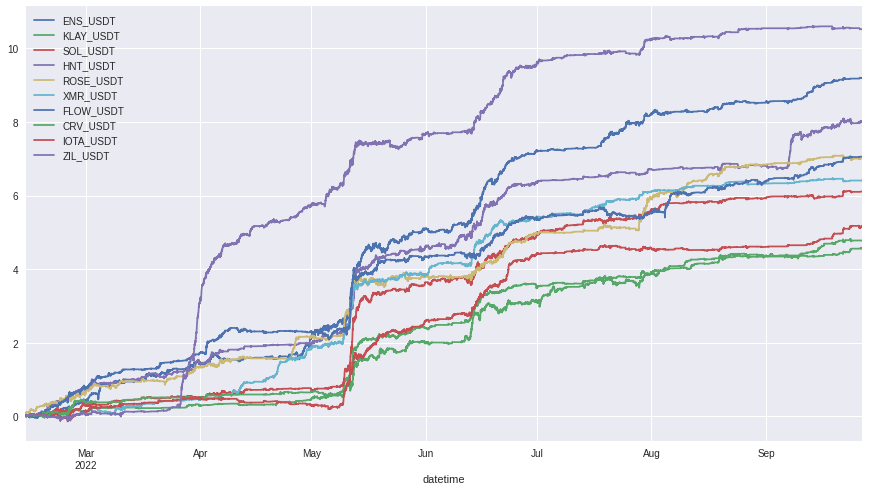

In [46]:
# Display cumulative returns of the strategies on the test set
# data = res.dropna().loc["2020-01":"2021-01"]
data = res[top_symbols_list].dropna()
data.cumsum().plot(figsize=(15,8))

In [47]:
# res['GNO_USDT'].isna().value_counts()

### 16.2.3. Apply portfolio management technics

In [48]:
# print("train set: 0 ", split_train_test)
# print("test set: ", split_train_test, split_test_valid)
# print("validate set: ", split_test_valid, " to end")

In [49]:
# !pip install yfinance

In [50]:
# get_data("BTC_USDT", data_len).dropna()["close"].pct_change(1).dropna()

In [51]:
# data['GNO_USDT'].isna().value_counts()

In [52]:
# 结果为NaN表示不存在nan值。
data.isna().apply(pd.value_counts)

,ENS_USDT,KLAY_USDT,SOL_USDT,HNT_USDT,ROSE_USDT,XMR_USDT,FLOW_USDT,CRV_USDT,IOTA_USDT,ZIL_USDT
False,21724,21724,21724,21724,21724,21724,21724,21724,21724,21724


In [53]:
# res["GNO_USDT"].isna().value_counts()

In [54]:
# res.iloc[split_test_valid:]

In [55]:

def backtest_dynamic_portfolio(dfc, ben="^GSPC", timeframe=252):
  """
  -----------------------------------------------------------------------------
  | Output: Beta CAPM metric                                                  |
  -----------------------------------------------------------------------------
  | Inputs: - weights (type 1d array numpy): weights of the portfolio         |
  |         - database (type dataframe pandas): Returns of the asset          |
  |         - ben (type string): Name of the benchmark                        |
  |         - timeframe (type int): annualization factor                      |
  -----------------------------------------------------------------------------
  """
  import pandas as pd
  import yfinance as yf
  import numpy as np
  from scipy.optimize import minimize
  import matplotlib.pyplot as plt
  plt.style.use('seaborn')
  import matplotlib as mpl
  import matplotlib.pyplot as plt

  from matplotlib import cycler


  font = {'weight' : 'bold', "size":"300"}
  plt.rc('font', **font)

  # Maybe from series to dataframe
  if str(type(dfc)) == "<class 'pandas.core.series.Series'>":
    dfc = pd.DataFrame(dfc)
    
  # find the returns
  if len(dfc.columns)==1:
    dfc.columns=["returns"]
    

  # CREATE DAILY RETURNS
  portfolio = dfc["returns"]
  if portfolio.index.name != "datetime":
      portfolio.index.name = "datetime"


  portfolio = portfolio.reset_index(drop=False)
#   portfolio.groupby(pd.Grouper(key='datetime',freq='d')).sum()
  portfolio.groupby(pd.Grouper(key='datetime')).sum()
  portfolio = portfolio.set_index("datetime")
  ######################### COMPUTE THE BETA ##################################
  # Importation of benchmark
  if ben == "^GSPC":
    benchmark = yf.download(ben)["Adj Close"].pct_change(1).dropna()
  else:
    benchmark = get_data("BTC_USDT").dropna()["close"].pct_change(1).dropna()

  # Concat the asset and the benchmark
  join = pd.concat((portfolio, benchmark), axis=1).dropna()

  # Covariance between the asset and the benchmark
  cov = np.cov(join, rowvar=False)[0][1]

  # Compute the variance of the benchmark
  var = np.cov(join, rowvar=False)[1][1]

  beta = cov/var


  ######################### COMPUTE THE ALPHA #################################
  # Mean of returns for the asset
  mean_stock_return = join.iloc[:,0].mean()*timeframe

  # Mean of returns for the market
  mean_market_return = join.iloc[:,1].mean()*timeframe

  # Alpha
  alpha = mean_stock_return - beta*mean_market_return


  ######################### COMPUTE THE SHARPE ################################
  mean = portfolio.mean() * np.sqrt(timeframe)
  std = portfolio.std() 
  Sharpe = (mean/std)[0]


  ######################### COMPUTE THE SORTINO ###############################
  downward = portfolio[portfolio<0]* np.sqrt(timeframe)
  std_downward = downward.std()
  Sortino = (mean/std_downward)[0]


  ######################### COMPUTE THE DRAWDOWN ###############################
  # Compute the cumulative product returns
  coef_rets = (portfolio+1).cumprod()
  cum_rets = coef_rets-1

  # Compute the running max
  running_max = np.maximum.accumulate(coef_rets.dropna())
  #running_max[running_max < 1] = 1

  # Compute the drawdown
  drawdown = ((coef_rets/running_max) - 1)
  min_drawdon = (-drawdown.min())[0]


  ######################### COMPUTE THE VaR ##################################
  theta = 0.01
  # Number of simulations
  n = 100000
  
  # Find the values for theta% error threshold
  t = int(n*theta)

  # Create a vector with n simulations of the normal law
  vec = pd.DataFrame(np.random.normal(mean, std, size=(n,)),columns = ["Simulations"])
  
  # Orderer the values and find the theta% value
  VaR = -vec.sort_values(by="Simulations").iloc[t].values[0]


  ######################### COMPUTE THE cVaR #################################
  cVaR = -vec.sort_values(by="Simulations").iloc[0:t,:].mean().values[0]

  ######################### TIME UNDERWATER ##################################
  tuw = len(drawdown[drawdown<0]) / len(drawdown)

  ######################### PLOT THE RESULTS #################################
  print(f"""
    -----------------------------------------------------------------------------
    Beta: {np.round(beta, 3)} \t Alpha: {np.round(alpha*100, 2)} %\t \
    Sharpe: {np.round(Sharpe, 3)} \t Sortino: {np.round(Sortino, 3)}
  -----------------------------------------------------------------------------
    VaR: {np.round(VaR*100, 2)} %\t cVaR: {np.round(cVaR*100, 2)} % \t \
    VaR/cVaR: {np.round(cVaR/VaR, 3)} \t drawdown: {np.round(min_drawdon*100, 2)} %
  -----------------------------------------------------------------------------""")
  

  plt.figure(figsize=(15,8))
  pd.plotting.register_matplotlib_converters()
  plt.plot(join.iloc[:,0].cumsum()*100, color="#035593", linewidth=3)
  plt.plot(join.iloc[:,1].cumsum()*100, color="#068C72", linewidth=3)
  plt.plot(cum_rets*100, color="#CE5151", linewidth=3)
  plt.title("CUMULTATIVE RETURN", size=15)
  plt.ylabel("Cumulative return %", size=15)
  plt.xticks(size=15,fontweight="bold")
  plt.yticks(size=15,fontweight="bold")
  plt.legend(["Strategy", "Benchmark", "cumProd"])
  plt.show()

  plt.figure(figsize=(15,8))
  pd.plotting.register_matplotlib_converters()
  plt.fill_between(drawdown.index, drawdown.iloc[:,0]*100, 0, color="#CE5151")
  plt.plot(drawdown.index,drawdown.iloc[:,0]*100, color="#930303", linewidth=3)
  plt.title("DRAWDOWN", size=15)
  plt.ylabel("Drawdown %", size=15)
  plt.xticks(size=15,fontweight="bold")
  plt.yticks(size=15,fontweight="bold")
  plt.show()

In [56]:
# def my_MV_criterion(weights, data):
#     """
#     -----------------------------------------------------------------------------
#     | Output: optimization porfolio criterion                                   |
#     -----------------------------------------------------------------------------
#     | Inputs: -weight (type ndarray numpy): Wheight for portfolio               |
#     |         -data (type ndarray numpy): Returns of stocks                     |
#     -----------------------------------------------------------------------------
#     """

#     # Parameters
#     Lambda = 3
#     W = 1
#     Wbar = 1 + 0.25 / 100

#     # Compute portfolio returns
#     portfolio_return = np.multiply(data, np.transpose(weights))
#     portfolio_return = portfolio_return.sum(axis=1)

#     # Compute mean and volatility of the portfolio
#     mean = np.mean(portfolio_return, axis=0)
#     std = np.std(portfolio_return, axis=0)

#     # Compute the criterion
#     criterion = Wbar ** (1 - Lambda) / (1 + Lambda) + Wbar ** (-Lambda) \
#                 * W * mean - Lambda / 2 * Wbar ** (-1 - Lambda) * W ** 2 * std ** 2
#     criterion = -criterion
#     print(weights)
#     print(mean, std, criterion)
#     return criterion

def my_MV_criterion(weight,Returns_data):
    """ 
    ------------------------------------------------------------------------------
    | Output: optimization porfolio criterion                                    |
    ------------------------------------------------------------------------------
    | Inputs: -weight (type ndarray numpy): Wheight for portfolio                |
    |         -Returns_data (type ndarray numpy): Returns of stocks              |
    ------------------------------------------------------------------------------
    """
    portfolio_return=np.multiply(Returns_data,np.transpose(weight));
    portfolio_return=np.sum(portfolio_return,1);
    mean_ret=np.mean(portfolio_return,0)
    sd_ret=np.std(portfolio_return,0)
    criterion = sd_ret
#     criterion = zero_divide(mean_ret, sd_ret)
#     print(mean_ret, sd_ret)
    return criterion

def my_optimization_portfolio(criterion, data):

    # Find the number of asset
    n=data.shape[1]

    # Initialisation weight value
#     x0 = np.ones(n)
    x0 = np.zeros(n)

    # Optimization constraints problem
    cons=({'type':'eq', 'fun': lambda x:sum(abs(x))-1})

    # Set the bounds
    Bounds= [(0 , 1) for i in range(0,n)]


    # Optimization problem solving
    res_SK = minimize(criterion, x0, method="SLSQP",
                      args=(data),bounds=Bounds,
                      constraints=cons,options={'disp': True})

    # Result for computations
    X = res_SK.x
    return X

In [57]:
low_assets

,ENS_USDT,KLAY_USDT,SOL_USDT,HNT_USDT,ROSE_USDT,XMR_USDT,FLOW_USDT,CRV_USDT,IOTA_USDT,ZIL_USDT
datetime,,,,,,,,,,
2021-12-02 18:15:00,-0.006767,-0.004267,-0.001164,-0.002224,NaN,-0.005141,NaN,-0.005311,-0.000647,-0.002324
2021-12-02 18:30:00,-0.001303,-0.000612,-0.014727,-0.004324,NaN,-0.000546,NaN,-0.010023,-0.003143,-0.001874
2021-12-02 18:45:00,-0.005798,-0.003912,-0.012027,-0.004962,NaN,-0.006158,NaN,-0.005294,-0.005896,-0.002914
2021-12-02 19:00:00,-0.002778,-0.002351,-0.009747,-0.002316,NaN,-0.000083,NaN,-0.007389,-0.001034,-0.002907
2021-12-02 19:15:00,-0.000383,-0.000336,-0.003477,-0.004888,NaN,-0.003381,NaN,-0.004422,-0.006262,-0.003019
...,...,...,...,...,...,...,...,...,...,...
2022-09-27 00:15:00,-0.009404,-0.001460,-0.012041,-0.002969,-0.003382,-0.006006,-0.004197,-0.007495,-0.005428,-0.005000
2022-09-27 00:30:00,-0.011946,-0.000000,-0.001753,-0.003189,-0.001285,-0.000339,-0.001195,-0.002132,-0.005404,-0.001867
2022-09-27 00:45:00,-0.010181,-0.003908,-0.004688,-0.006801,-0.004023,-0.006953,-0.005396,-0.005336,-0.003839,-0.005613


Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.002507757483446116
            Iterations: 11
            Function evaluations: 121
            Gradient evaluations: 11
[0.014 0.323 0.053 0.045 0.014 0.188 0.046 0.106 0.181 0.031]

    -----------------------------------------------------------------------------
    Beta: 0.002 	 Alpha: 6.59 %	     Sharpe: 1.655 	 Sortino: 0.127
  -----------------------------------------------------------------------------
    VaR: 0.17 %	 cVaR: 0.26 % 	     VaR/cVaR: 1.503 	 drawdown: 9.14 %
  -----------------------------------------------------------------------------


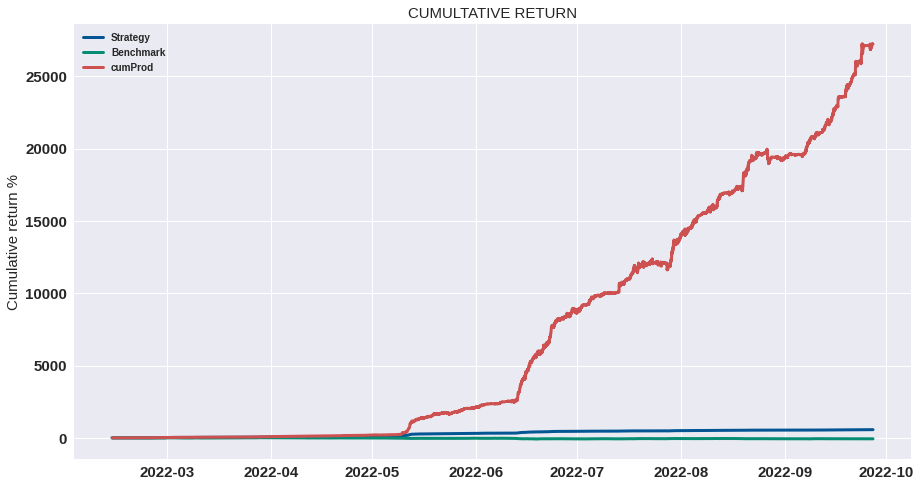

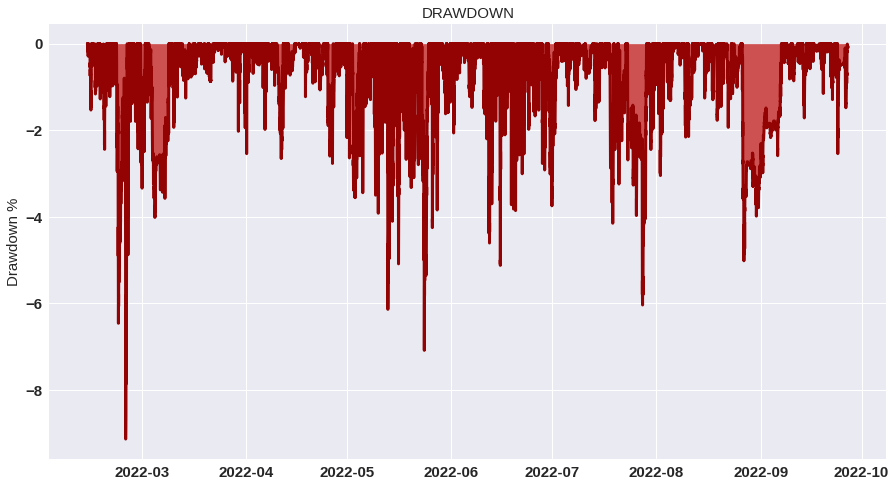

In [58]:
from lib.portfolio import *
# data = res.dropna().loc["2020-01":"2021-01"]
data = res[top_symbols_list].dropna().iloc[:split_test_valid]
# val = res.dropna().loc["2021-01":]
if is_PROD:
    val = data
else:
    val = res[top_symbols_list].dropna().iloc[split_test_valid:]

# X = optimization_portfolio(MV_criterion, data)
X = my_optimization_portfolio(my_MV_criterion, data)
# X = optimization_portfolio(RaR_criterion, data)

print(np.round(X,3))

selected_low_assets = low_assets[top_symbols_list]
selected_high_assets = high_assets[top_symbols_list]

# spread = 0.00035
low_portfolio = np.multiply(selected_low_assets,np.transpose(X)).sum(axis=1)
high_portfolio = np.multiply(selected_high_assets,np.transpose(X)).sum(axis=1)


# Compute the cumulative return of the portfolio (CM)
portfolio_return_test = np.multiply(data,np.transpose(X)).sum(axis=1)

# 注意，这里用的验证集的数据。
portfolio_return_MV = np.multiply(val,np.transpose(X)).sum(axis=1)


# import sys
# sys.path.append("./lib")
# from Backtest import *
# from imp import reload 
# import Backtest
# reload(Backtest)

# # # from Backtest import *
# # import yfinance as yf

backtest_dynamic_portfolio(portfolio_return_MV, ben="BTC_USDT")

In [59]:
portfolio_return_MV

datetime
2022-02-12 18:15:00    0.003057
2022-02-12 18:30:00   -0.000111
2022-02-12 18:45:00    0.000798
2022-02-12 19:00:00    0.000524
2022-02-12 19:15:00   -0.000339
                         ...   
2022-09-27 00:00:00    0.000000
2022-09-27 00:15:00    0.000000
2022-09-27 00:30:00    0.000154
2022-09-27 00:45:00    0.000000
2022-09-27 01:00:00    0.000000
Length: 21724, dtype: float64

## calculate Spread for selected assets

In [60]:
selected_spread = []
for symbol in transformed_assets:
    selected_spread.append(spread_df.loc[symbol])

In [61]:
pd.DataFrame(selected_spread).describe()

,spread
count,10.000000
mean,0.000366
std,0.000298
min,0.000067
25%,0.000168
50%,0.000303
75%,0.000470
max,0.001068


In [62]:
spread = pd.DataFrame(selected_spread).describe().loc["75%"]["spread"]
spread

0.0004698047494822385

### 14.3.1. Optimal take profit

In [63]:
def find_best_tp(tp):
    tp = tp/100
    
    # Create the portfolio
    pf = pd.concat((low_portfolio, portfolio_return_test, high_portfolio), axis=1).dropna()-spread
#     pf = pd.concat((low_portfolio, portfolio_return_test, high_portfolio), axis=1).dropna()
    pf.columns = ["low", "Return", "high"]

    # Apply the tp
    pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
    pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)
    down = pf["Return"].values
    down = down[down<0]
    
    # Return sharpe raatio
    return np.sqrt(252)*pf["Return"].mean()/down.std()

tp_df=pd.DataFrame([find_best_tp(tp) for tp in np.linspace(0.5,10,30)],  index=np.linspace(0.5,10,30), columns=["Sharpe"])
tp_df

,Sharpe
0.500000,5.687856
0.827586,1.060732
1.155172,-0.519403
1.482759,-1.231167
1.810345,-1.488925
2.137931,-1.669841
2.465517,-1.748564
2.793103,-1.847036
3.120690,-1.851871
3.448276,-1.847809


In [64]:
tp_df.Sharpe.idxmax()

0.5


    -----------------------------------------------------------------------------
    Beta: -0.115 	 Alpha: 13.97 %	     Sharpe: 3.275 	 Sortino: 0.358
  -----------------------------------------------------------------------------
    VaR: -0.26 %	 cVaR: -0.17 % 	     VaR/cVaR: 0.652 	 drawdown: 9.16 %
  -----------------------------------------------------------------------------


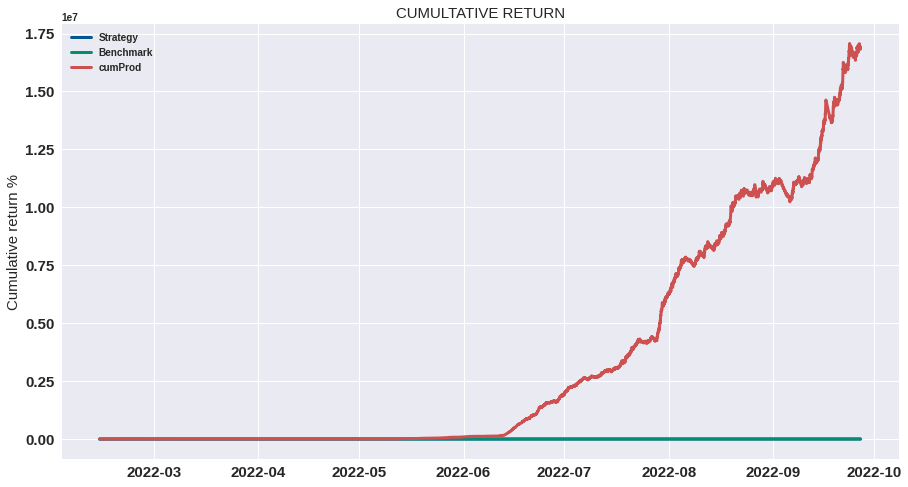

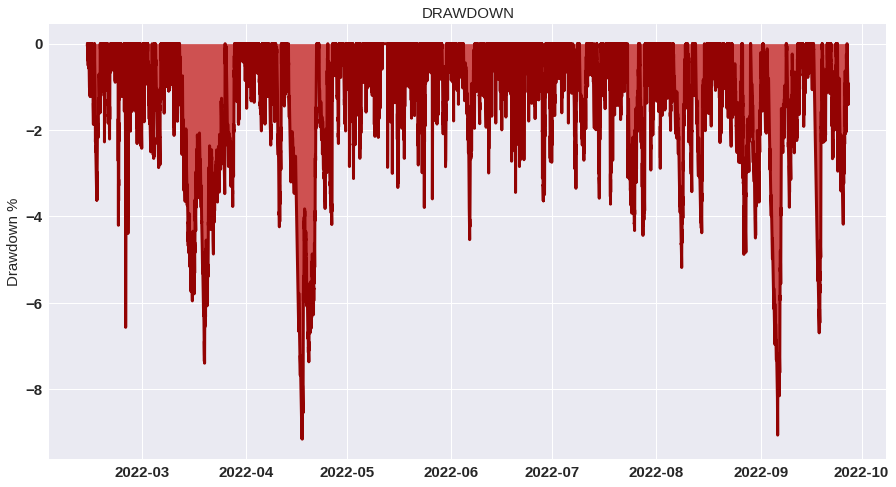

In [65]:
# tp = 0.5/100
tp = np.round(tp_df.Sharpe.idxmax(), 2)/100
pf = pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()-spread
# pf = pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()
pf.columns = ["low", "Return", "high"]

pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)

backtest_dynamic_portfolio(pf["Return"], ben="BTC_USDT")

In [66]:
pf

,low,Return,high
datetime,,,
2022-02-12 18:15:00,-0.002778,0.002587,0.003755
2022-02-12 18:30:00,-0.002302,-0.000581,0.002953
2022-02-12 18:45:00,-0.001800,0.000328,0.001743
2022-02-12 19:00:00,-0.003626,0.005000,0.007871
2022-02-12 19:15:00,-0.001372,0.005000,0.006827
...,...,...,...
2022-09-27 00:00:00,-0.010985,-0.000470,0.002640
2022-09-27 00:15:00,-0.005139,-0.000470,0.002547
2022-09-27 00:30:00,-0.002274,0.005000,0.005590


### 16.3.2. Optimal stop loss

In [67]:
def find_best_sl(sl):
    sl = sl/100
    
    # Create the portfolio
    pf = pd.concat((low_portfolio, portfolio_return_test,high_portfolio), axis=1).dropna()-spread
#     pf = pd.concat((low_portfolio, portfolio_return_test,high_portfolio), axis=1).dropna()
    pf.columns = ["low", "Return", "high"]

    # Apply the tp
    pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
    pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)
    
    # Return sharpe raatio
    return np.sqrt(252)*pf["Return"].mean()/pf["Return"].std()

sl_df = pd.DataFrame([find_best_sl(sl) for sl in np.linspace(1,10,30)],  index=np.linspace(1,10,30), columns=["Sharpe"])
sl_df

,Sharpe
1.000000,-2.791871
1.310345,-2.086398
1.620690,-1.772590
1.931034,-1.555050
2.241379,-1.448403
2.551724,-1.410565
2.862069,-1.352204
3.172414,-1.346725
3.482759,-1.325605
3.793103,-1.320965


In [68]:
sl_df.Sharpe.idxmax()

6.8965517241379315


    -----------------------------------------------------------------------------
    Beta: 0.008 	 Alpha: -5.31 %	     Sharpe: -1.314 	 Sortino: -0.12
  -----------------------------------------------------------------------------
    VaR: 0.93 %	 cVaR: 1.01 % 	     VaR/cVaR: 1.091 	 drawdown: 99.05 %
  -----------------------------------------------------------------------------


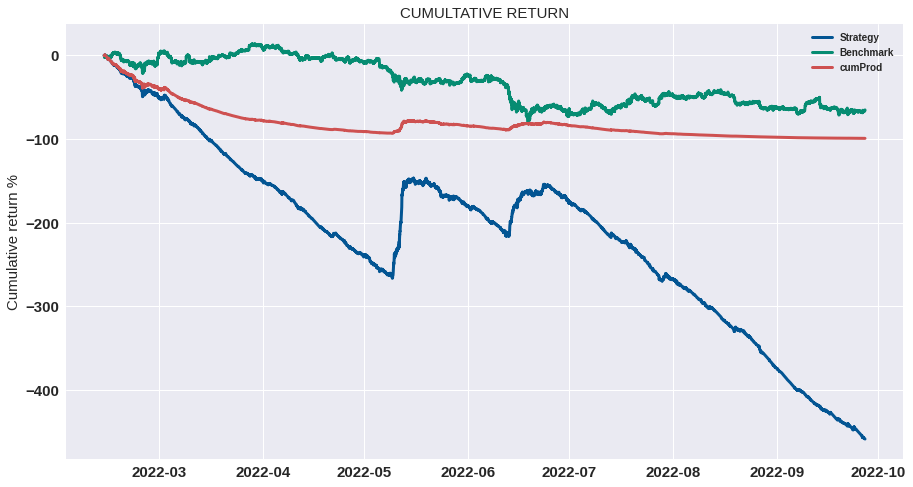

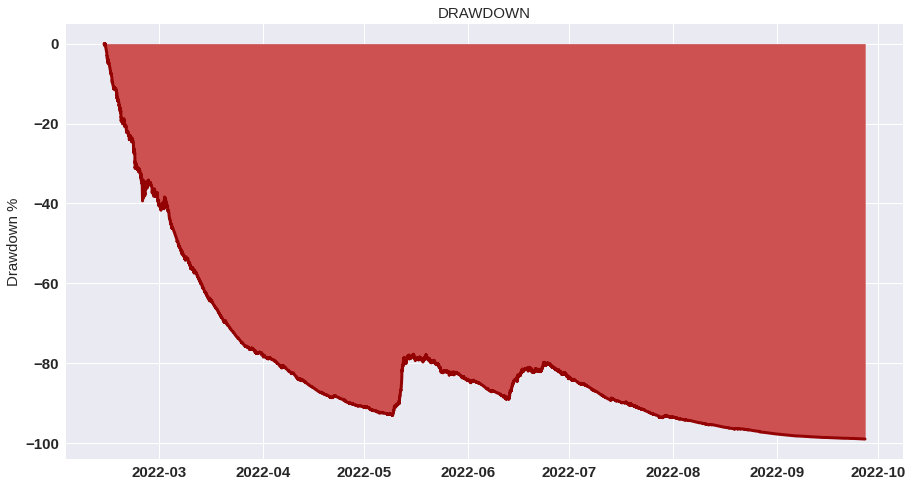

In [69]:
# sl = 2.56/100
sl = np.round(sl_df.Sharpe.idxmax(), 2)/100
pf = pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()-spread
# pf = pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()

pf.columns = ["low", "Return", "high"]
pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)


backtest_dynamic_portfolio(pf["Return"], ben="BTC_USDT")

### 14.3.3. Optimal leverage

In [70]:
print(tp, sl)

0.005 0.069



    -----------------------------------------------------------------------------
    Beta: -0.107 	 Alpha: 13.89 %	     Sharpe: 3.207 	 Sortino: 0.333
  -----------------------------------------------------------------------------
    VaR: -0.24 %	 cVaR: -0.14 % 	     VaR/cVaR: 0.59 	 drawdown: 9.16 %
  -----------------------------------------------------------------------------


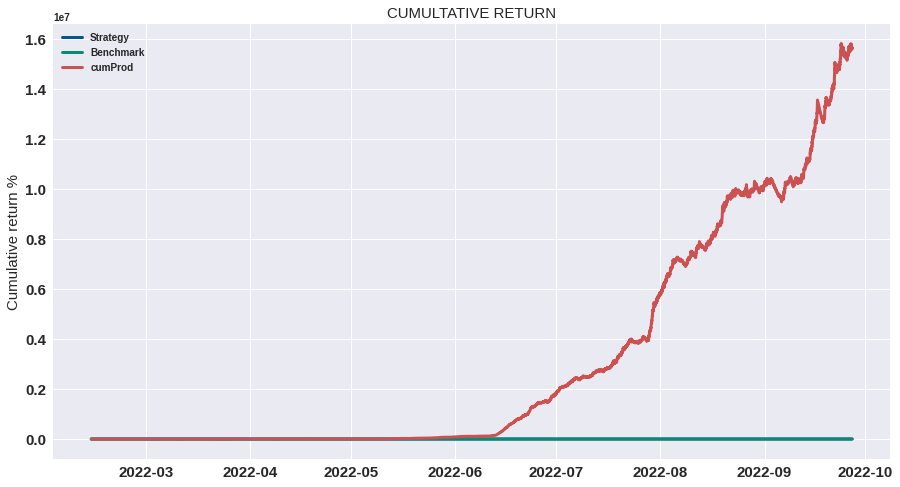

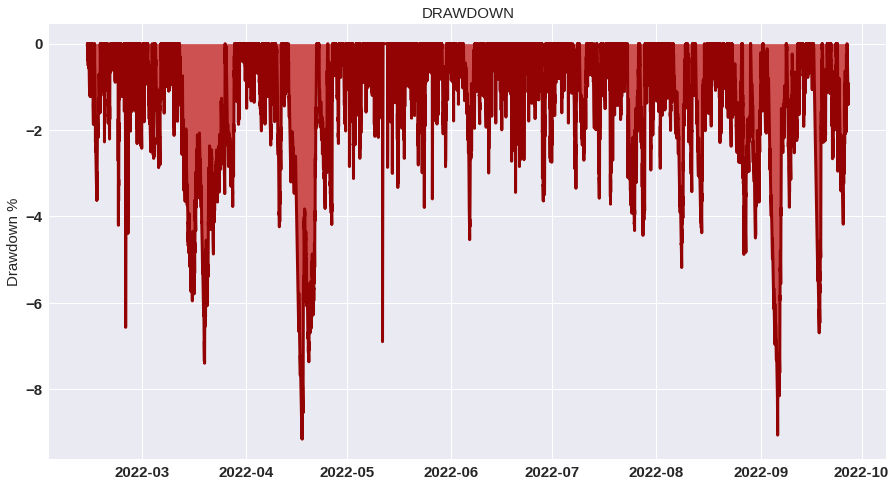

In [71]:
leverage = 1
# tp = 0.8/100
# sl = 2.56/100
pf = (pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna()-spread)*leverage
# pf = (pd.concat((low_portfolio, portfolio_return_MV,high_portfolio), axis=1).dropna())*leverage
pf.columns = ["low", "Return", "high"]

pf["Return"] = np.where(pf["high"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values>tp, tp, pf["Return"].values)
pf["Return"] = np.where(pf["low"].values<-sl, -sl, pf["Return"].values)
pf["Return"] = np.where(pf["Return"].values<-sl, -sl, pf["Return"].values)

# Plot the CM
backtest_dynamic_portfolio(pf["Return"], ben="BTC_USDT")

In [72]:
# validation
pf["Return"]

datetime
2022-02-12 18:15:00    0.002587
2022-02-12 18:30:00   -0.000581
2022-02-12 18:45:00    0.000328
2022-02-12 19:00:00    0.005000
2022-02-12 19:15:00    0.005000
                         ...   
2022-09-27 00:00:00   -0.000470
2022-09-27 00:15:00   -0.000470
2022-09-27 00:30:00    0.005000
2022-09-27 00:45:00   -0.000470
2022-09-27 01:00:00   -0.000470
Freq: 15T, Name: Return, Length: 21724, dtype: float64

Why has the performance does not grown since 06-2021? There are some explanations. The period's volatility is less than the other, and the strategy does not work on it, or the weight of the algorithm needs to be adjusted because the market situation has evolved.

Congratulations!

You have read the whole book. It is normal if you do not have to understand all the notions. To a better understanding, I advise you to use your news skills in your projects.


### 使用以上参数，按品种，做实际的回测

In [73]:
predictions

,ENS_USDT,KLAY_USDT,SOL_USDT,HNT_USDT,ROSE_USDT,XMR_USDT,FLOW_USDT,CRV_USDT,IOTA_USDT,ZIL_USDT
datetime,,,,,,,,,,
2021-12-02 18:15:00,1,1.0,-1.0,0.0,NaN,1.0,NaN,1,-1.0,0
2021-12-02 18:30:00,1,1.0,-1.0,0.0,NaN,1.0,NaN,-1,1.0,1
2021-12-02 18:45:00,-1,-1.0,-1.0,0.0,NaN,-1.0,NaN,-1,-1.0,0
2021-12-02 19:00:00,-1,-1.0,-1.0,0.0,NaN,-1.0,NaN,-1,-1.0,0
2021-12-02 19:15:00,1,1.0,-1.0,0.0,NaN,1.0,NaN,-1,-1.0,0
...,...,...,...,...,...,...,...,...,...,...
2022-09-27 00:15:00,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0
2022-09-27 00:30:00,0,0.0,-1.0,0.0,0.0,0.0,0.0,0,0.0,0
2022-09-27 00:45:00,0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0


In [74]:
# # 合并
# merge_data = pd.concat((val, prediction), axis=1).dropna()
# merge_data

In [75]:
orig_data = {}
for symbol in top_symbols_list:
    print(symbol)
    
    # Import the data
    orig_data[symbol] = get_data(symbol, data_len).dropna()

ENS_USDT
KLAY_USDT
SOL_USDT
HNT_USDT
ROSE_USDT
XMR_USDT
FLOW_USDT
CRV_USDT
IOTA_USDT
ZIL_USDT


In [76]:
orig_data

{'ENS_USDT':                        open    high     low   close    volume
 datetime                                                     
 2021-11-30 03:30:00  70.850  70.850  67.890  68.051    6470.5
 2021-11-30 03:45:00  68.027  69.791  67.607  69.283    3248.2
 2021-11-30 04:00:00  69.310  70.748  68.728  70.537    4360.8
 2021-11-30 04:15:00  70.540  70.980  68.956  69.800    3531.7
 2021-11-30 04:30:00  69.813  70.023  68.921  69.053    1706.1
 ...                     ...     ...     ...     ...       ...
 2022-09-27 00:15:00  14.993  15.135  14.989  15.068  106556.3
 2022-09-27 00:30:00  15.066  15.248  15.022  15.225  183707.9
 2022-09-27 00:45:00  15.227  15.380  15.210  15.325  152208.3
 2022-09-27 01:00:00  15.323  15.480  15.310  15.443  209719.9
 2022-09-27 01:15:00  15.447  15.447  15.334  15.365   52881.7
 
 [28888 rows x 5 columns],
 'KLAY_USDT':                        open    high     low   close     volume
 datetime                                                      

In [77]:
def run_tp_sl(data, leverage=1, tp=0.015, sl=-0.015, cost=0.0004, weight=1):
    print("run with tp ", tp, " sl ", sl, "weight ", weight)
    buy=False
    sell=False
    
    buy_count = 0
    sell_count = 0
    for i in range(len(data)):
        row = data.iloc[i]
        
        cur_ret = 0
        
        # 在
        # 当前buy，但预测信号为卖出
        if buy==True and row["Signal"]==-1:
            # close 掉买单。已开仓价
            cur_ret += (row["open"] - open_buy_price) / open_buy_price

            buy = False
            open_buy_price =None
            var_buy_high = 0
            var_buy_low = 0
            open_buy_date = None
            
        # 当前sell, 单预测信号为买入
        if sell==True and row["Signal"]==1:
            cur_ret += -(row["open"] - open_sell_price)/open_sell_price                 
            sell = False
            open_sell_price =None
            var_sell_high = 0
            var_sell_low = 0
            open_sell_date = None

            
            
        if buy==False and row["Signal"]==1:
            buy = True
            buy_count = buy_count + 1
            open_buy_price = row["open"]
            open_buy_date = row.name
                      
            
        if buy:
            # 计算开仓后高点的比例
            var_buy_high = (row["high"] - open_buy_price) / open_buy_price
            # 计算开仓后低点的比例
            var_buy_low = (row["low"] - open_buy_price) / open_buy_price
            
            # 保守期间，先判断sl止损，再判断tp止盈 
            if var_buy_low < sl:
                cur_ret += sl-cost
            elif var_buy_high > tp:
                cur_ret += tp-cost
            
            if var_buy_low < sl or var_buy_high > tp:
                data.loc[row.name, "return"] = cur_ret*leverage*weight
                buy = False
                open_buy_price =None
                var_buy_high = 0
                var_buy_low = 0
                open_buy_date = None
                
        if sell==False and row["Signal"]==-1:
            sell = True
            sell_count = sell_count + 1
            open_sell_price = row["open"]
            open_sell_date = row.name
            
        if sell:
            var_sell_high = -(row["high"] - open_sell_price)/open_sell_price
            var_sell_low = -(row["low"] - open_sell_price)/open_sell_price
            
            if var_sell_low > tp:
                cur_ret += tp-cost
            elif var_sell_high < sl:
                cur_ret += sl-cost

            if var_sell_low > tp or var_sell_high < sl:
                data.loc[row.name, "return"] = cur_ret*leverage*weight                   
                sell = False
                open_sell_price =None
                var_sell_high = 0
                var_sell_low = 0
                open_sell_date = None
        
                
#         if row["Signal"]== 0:
#             # 注意，遇到signal为0时，平仓。这里平仓价用open价格。(类似于，signal预测到开仓时，也用的open价格)
#             if buy:           
#                 close_ret = (row["open"] - open_buy_price) / open_buy_price

#                 cur_ret = close_ret - cost
#                 data.loc[row.name, "return"] = cur_ret*leverage*weight
#                 buy = False
#                 open_buy_price =None
#                 open_buy_date = None

#             if sell:
#                 close_ret = -(row["open"] - open_sell_price) / open_sell_price

#                 cur_ret = close_ret - cost
#                 data.loc[row.name, "return"] = cur_ret*leverage*weight
#                 sell = False
#                 open_sell_price =None
#                 open_sell_date = None
                
    # end for
    data["return"] = data["return"].fillna(value=0)
    print("buy ", buy_count, " sell ", sell_count)
    return data
            

In [78]:
symbol_weights = pd.DataFrame({"symbol":top_symbols_list, "weights":X}).set_index("symbol")
symbol_weights

,weights
symbol,
ENS_USDT,0.014149
KLAY_USDT,0.322728
SOL_USDT,0.052643
HNT_USDT,0.045230
ROSE_USDT,0.014050
XMR_USDT,0.187575
FLOW_USDT,0.045550
CRV_USDT,0.105615
IOTA_USDT,0.181168


In [79]:
final_test_res = pd.DataFrame()
for symbol in top_symbols_list:
    print(symbol)
    cur_data = orig_data[symbol]
    # 合并预测数据和原始数据,并获取验证集的数据
    if is_PROD:
        merge_data = pd.concat((cur_data, predictions[symbol]), axis=1).dropna()
    else:
        merge_data = pd.concat((cur_data, predictions[symbol]), axis=1).iloc[split_test_valid:].dropna()
    merge_data = merge_data.rename({merge_data.columns[-1]: 'Signal'}, axis=1)

#     for i in range(2):
#         row = data.iloc[i]
#         print(row.name)
    # 注意sl加负号
    run_tp_sl(merge_data, tp=tp, sl=-sl, weight=symbol_weights.loc[symbol,"weights"])
#     run_tp_sl(merge_data, tp=tp, sl=-sl, weight=0.1, use_HL_ret=True)
    final_test_res[symbol] = merge_data["return"]

ENS_USDT
run with tp  0.005  sl  -0.069 weight  0.014149068698736274
buy  2884  sell  3403
KLAY_USDT
run with tp  0.005  sl  -0.069 weight  0.3227276860020449
buy  2597  sell  2568
SOL_USDT
run with tp  0.005  sl  -0.069 weight  0.052642785631572084
buy  2592  sell  2745
HNT_USDT
run with tp  0.005  sl  -0.069 weight  0.045229580334627054
buy  3072  sell  2684
ROSE_USDT
run with tp  0.005  sl  -0.069 weight  0.014050311126361317
buy  2604  sell  2729
XMR_USDT
run with tp  0.005  sl  -0.069 weight  0.18757525945601103
buy  2555  sell  2523
FLOW_USDT
run with tp  0.005  sl  -0.069 weight  0.04555012036085998
buy  1862  sell  2285
CRV_USDT
run with tp  0.005  sl  -0.069 weight  0.1056149289616899
buy  2726  sell  3293
IOTA_USDT
run with tp  0.005  sl  -0.069 weight  0.18116821313508952
buy  2392  sell  2296
ZIL_USDT
run with tp  0.005  sl  -0.069 weight  0.031292046293008045
buy  2594  sell  2558


<AxesSubplot:xlabel='datetime'>

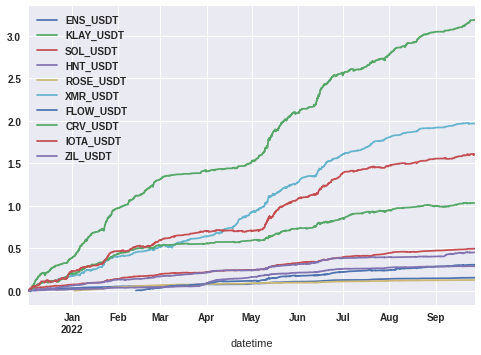

In [80]:
final_test_res.cumsum().plot()

<AxesSubplot:xlabel='datetime'>

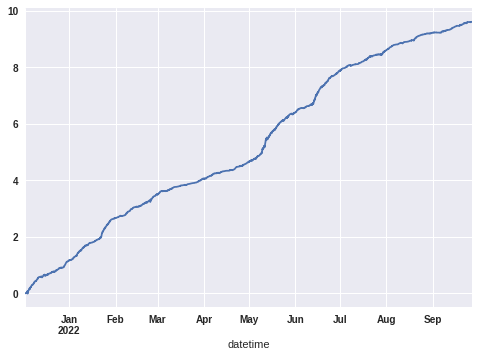

In [81]:
# 先把所有symbol按行sum，再cumsum()累加所有的return
final_test_res.sum(axis=1).cumsum().plot()

In [82]:
# 按品种计算sharp
np.sqrt(365)*final_test_res.mean()/final_test_res.std()

ENS_USDT     1.347228
KLAY_USDT    2.654474
SOL_USDT     1.599019
HNT_USDT     1.494302
ROSE_USDT    1.332586
XMR_USDT     2.225238
FLOW_USDT    1.347082
CRV_USDT     1.386590
IOTA_USDT    1.747864
ZIL_USDT     1.369954
dtype: float64

In [83]:
# 合并计算sharpe
total_ret=final_test_res.sum(axis=1).cumsum()
np.sqrt(365)*total_ret.mean()/total_ret.std()

34.89454458401842


    -----------------------------------------------------------------------------
    Beta: 0.018 	 Alpha: 8.47 %	     Sharpe: 3.478 	 Sortino: 0.079
  -----------------------------------------------------------------------------
    VaR: -0.18 %	 cVaR: -0.13 % 	     VaR/cVaR: 0.719 	 drawdown: 8.94 %
  -----------------------------------------------------------------------------


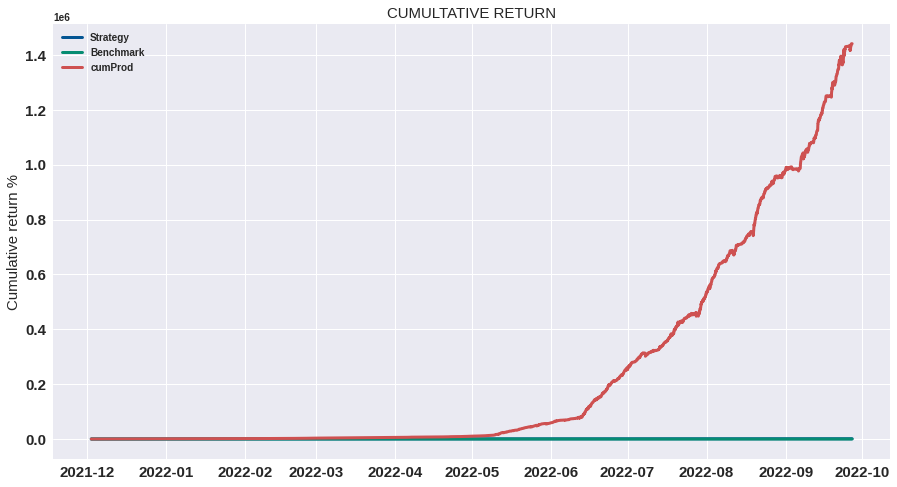

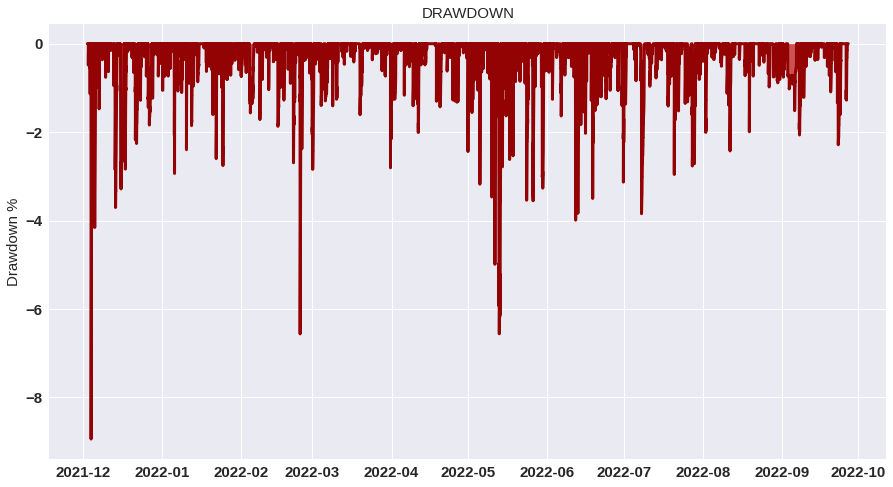

In [84]:
backtest_dynamic_portfolio(final_test_res.sum(axis=1), ben="BTC_USDT")

In [85]:
total_df

,CVX_USDT,RVN_USDT,VET_USDT,RUNE_USDT,GMT_USDT,NEAR_USDT,MANA_USDT,DOT_USDT,ALGO_USDT,MATIC_USDT,...,LRC_USDT,KAVA_USDT,KLAY_USDT,1INCH_USDT,COMP_USDT,IOST_USDT,ETH_USDT,ZEC_USDT,EGLD_USDT,DOGE_USDT
datetime,,,,,,,,,,,,,,,,,,,,,
2022-09-22 12:15:00,4.686,0.03986,0.02267,1.627,0.6291,3.879,0.7111,6.449,0.3713,0.7489,...,0.3077,1.4916,0.2077,0.5830,57.09,0.012176,1305.63,55.00,47.67,0.05928
2022-09-22 12:30:00,4.668,0.03972,0.02266,1.632,0.6312,3.871,0.7098,6.450,0.3737,0.7497,...,0.3072,1.4917,0.2075,0.5830,57.11,0.012158,1308.00,54.99,47.68,0.05913
2022-09-22 12:45:00,4.710,0.04001,0.02267,1.633,0.6307,3.870,0.7110,6.457,0.3800,0.7500,...,0.3084,1.4948,0.2080,0.5855,57.29,0.012179,1306.05,55.16,47.82,0.05930
2022-09-22 13:00:00,4.686,0.03990,0.02266,1.628,0.6292,3.873,0.7133,6.436,0.3725,0.7483,...,0.3078,1.4994,0.2077,0.5831,57.33,0.012179,1302.90,55.14,47.65,0.05927
2022-09-22 13:15:00,4.630,0.03963,0.02250,1.618,0.6267,3.824,0.7065,6.399,0.3685,0.7428,...,0.3047,1.4892,0.2057,0.5798,56.76,0.012111,1294.71,54.82,47.55,0.05893
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-27 00:15:00,4.790,0.03773,0.02286,1.609,0.6552,3.704,0.7075,6.595,0.3684,0.7590,...,0.3020,1.5126,0.2054,0.6290,62.66,0.012096,1339.53,59.22,47.14,0.06133
2022-09-27 00:30:00,4.803,0.03760,0.02281,1.608,0.6628,3.695,0.7065,6.582,0.3673,0.7578,...,0.3014,1.5106,0.2047,0.6280,62.55,0.012059,1339.20,58.97,47.01,0.06128
2022-09-27 00:45:00,4.806,0.03762,0.02283,1.612,0.6737,3.706,0.7083,6.604,0.3678,0.7589,...,0.3029,1.5137,0.2053,0.6317,62.75,0.012082,1342.11,59.09,47.07,0.06141


# 生成最终参数csv文件

In [86]:
print(tp, sl)

0.005 0.069


In [87]:
params = pd.DataFrame({"asset":top_symbols_list, "init_weights":X, "tp":[tp]*len(X) , "sl":[-sl]*len(X)  }).set_index("asset")
params

,init_weights,tp,sl
asset,,,
ENS_USDT,0.014149,0.005,-0.069
KLAY_USDT,0.322728,0.005,-0.069
SOL_USDT,0.052643,0.005,-0.069
HNT_USDT,0.045230,0.005,-0.069
ROSE_USDT,0.014050,0.005,-0.069
XMR_USDT,0.187575,0.005,-0.069
FLOW_USDT,0.045550,0.005,-0.069
CRV_USDT,0.105615,0.005,-0.069
IOTA_USDT,0.181168,0.005,-0.069


In [88]:
params.to_csv("./PROD/prod_params.csv")

In [35]:
import datetime
pd.Timestamp(datetime.datetime.utcnow()).ceil(freq='1H').strftime("%H:%M:%S")

'14:00:00'

In [34]:
import datetime
pd.Timestamp(datetime.datetime.utcnow() + datetime.timedelta(hours=4)).floor(freq='1H').strftime("%H:%M:%S")

'17:00:00'

In [36]:
def next_run_time(time_interval, ahead_seconds=5):
    if time_interval.endswith('m') or time_interval.endswith('h'):
        pass
    elif time_interval.endswith('T'):
        time_interval = time_interval.replace('T', 'm')
    elif time_interval.endswith('H'):
        time_interval = time_interval.replace('H', 'h')
    else:
        print('time_interval format wrong!! program exit!!')
        exit()

    print("")
    ti = pd.to_timedelta(time_interval)
    now_time = datetime.datetime.now()
    # now_time = datetime(2019, 5, 9, 23, 50, 30)  # 修改now_time，可用于测试
    this_midnight = now_time.replace(hour=0, minute=0, second=0, microsecond=0)
    min_step = datetime.timedelta(minutes=1)

    target_time = now_time.replace(second=0, microsecond=0)

    while True:
        target_time = target_time + min_step
        delta = target_time - this_midnight
        if delta.seconds % ti.seconds == 0 and (target_time - now_time).seconds >= ahead_seconds:
            # 当符合运行周期，并且目标时间有足够大的余地，默认为60s
            break

    print('next target time', target_time, '\n')
    return target_time

    

In [37]:
next_run_time("4H")

next target time 2022-11-09 12:00:00 



datetime.datetime(2022, 11, 9, 12, 0)

In [42]:
pd.Timestamp(datetime.datetime.now() + datetime.timedelta(hours=4)).floor(freq='1H').to_pydatetime()

datetime.datetime(2022, 11, 9, 15, 0)

In [38]:
pd.Timestamp(datetime.datetime.now() + datetime.timedelta(hours=4)).floor(freq='1H').strftime('%Y-%m-%d %H:%M:%S')

'2022-11-09 15:00:00'

In [ ]:
pd.Timestamp(datetime.datetime.now() + datetime.timedelta(hours=4)).floor(freq='1H').strftime("%H:%M:%S")